# Exploratory data analysis for the titanic data

In [1]:
!pip install powerlaw

In [2]:
!pip install xgboost

In [3]:
!pip install graphviz

In [4]:
!pip install lightgbm

In [5]:
# imports here
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from typing import List, Set, Dict, Tuple, Union, DefaultDict
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import chi2_contingency, chi2
import powerlaw
import re
import string
from sklearn import preprocessing
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from collections import defaultdict
from dython.nominal import associations
import itertools
import xgboost as xgb
from lightgbm import LGBMClassifier, LGBMRegressor
import warnings
warnings.filterwarnings("ignore")

In [6]:
titanic = pd.read_csv('data/train.csv')
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
1,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
2,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
3,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
4,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
707,107,1,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S
708,271,0,1,"Cairns, Mr. Alexander",male,NaN,0,0,113798,31.0000,NaN,S
709,861,0,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S
710,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,S


In [7]:
print(list(titanic.columns))

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [8]:
features = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

## Description of data columns:
1. Survived: Survived - 0 = No; 1 = Yes
2. Pclass: Ticket Class - 1 = 1st; 2 = 2nd; 3 = 3rd
3. Name: full name of passenger (including titles - Mr., Mrs., Miss, and Ms.)
4. Sex: male or female
5. Age: Age in years
6. SibSp: Number of siblings/spouses aboard the Titanic
7. Parch: Number of parents/children aboard the Titanic
8. Ticket: Ticket number
9. Fare: Passenger fare (how much paid for the cruise)
10. Cabin: Cabin number (titanic had 10 decks/floors - should be correlated with pclass somehow - my note)
11. Embarked: Port of Embarkation - C = Cherbourg, Q = Queenstown, S = Southampton

## Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## Notes of mine to examine
1. Titanic sank at night (2:20 a.m.) which means probably a lot of passengers were in their cabins, which gives upper decks/floors advantage in surviving - strong relation to cabin and pclass.
2. Most of passengers didn't survive, usually priority in evacuation is given to elders, children and women - could be of use
3. Internet says it took 160 minutes (2 hours and 40 minutes) the Titanic to sink - if priority was given then elders, children and women were saved widely.

In [9]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.9+ KB


In [10]:
num_passengers = len(titanic)
num_survived = len(titanic[titanic['Survived'] == 1])
survived_pct = num_survived / num_passengers
print(f"Total number of passengers={num_passengers}, survived={num_survived}, survived percentage={survived_pct:.3f}")

Total number of passengers=712, survived=268, survived percentage=0.376


### General statistics on the dataset

In [11]:
titanic.describe().applymap(lambda x: f"{x:0.3f}")

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000,712.000,712.000,572.000,712.000,712.000,712.000
mean,448.235,0.376,2.330,29.499,0.553,0.379,32.586
std,256.731,0.485,0.825,14.500,1.176,0.792,51.970
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,224.750,0.000,2.000,21.000,0.000,0.000,7.925
50%,453.500,0.000,3.000,28.000,0.000,0.000,14.454
75%,673.500,1.000,3.000,38.000,1.000,0.000,30.500
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [12]:
print("Missig values count and percent for each feature")
total = titanic.isnull().sum().sort_values(ascending=False)
percent = (titanic.isnull().sum() / titanic.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Missig values count and percent for each feature


,Total,Percent
Cabin,553,0.776685
Age,140,0.196629
Embarked,2,0.002809
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


### Issues List For the Dataset
-  Missing values in several columns: Cabin, Age and Embarked (maybe dropping Cabin column)
-  Processing string columns to numeric

# 1. Univariate Analysis: Examining each feature's statistics

### Categorical features functions

In [13]:
# Pie
def make_autopct(values):
    # custom function of printing in the pie chart
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

def pie_chart(df: pd.DataFrame, feature: str, categories: Union[List[str], List[int]]) -> None:
    # plotting counts and percentages of each category
    counts_per_category = [df[df[feature] == category].count()[feature] for category in categories]
    # Creating plot
    fig = plt.figure(figsize =(8, 5))
    plt.pie(counts_per_category, labels=categories, autopct=make_autopct(counts_per_category), textprops={'fontsize': 14})
    plt.suptitle(feature, fontsize=18);

In [14]:
# calculate for each category count and percent (probably too much categories for pie chart)
def create_df_for_numeric_cateforical(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    # using PassengerId because it has no missing values
    count_per_category = df[['PassengerId', feature]].groupby(feature).count()
    count_per_category.rename(columns={'PassengerId': 'Count'}, inplace=True)
    count_per_category['Percent'] = count_per_category['Count'] / count_per_category['Count'].sum()
    count_per_category.sort_values(by=['Count'], ascending=False, inplace=True)
    return count_per_category

In [15]:
def count_plot(df: pd.DataFrame, feature: str) -> None:
    figure, _ = plt.subplots(figsize=(10, 5))
    ax = df[feature].value_counts(normalize=True, ascending=True).plot.barh()
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f')
    plt.title(f'Normalized Counts per Category of {feature}')
    plt.xlabel('Normalized Count')
    plt.ylabel(feature)
    plt.xlim([0.0, 1.0]);
    plt.xticks(np.arange(0, 1.1, step=0.1));
    plt.show();

In [16]:
# Relationship with Survived column
def fill_categories_in_count(count_df: pd.DataFrame, all_categories: List[str]):
    count_categories = list(count_df.index)
    for category in all_categories:
        if category not in count_categories:
            count_df.loc[category] = 0
    count_df = count_df.sort_index(ascending=True)
    return count_df

def survival_rate_per_category_plot(df: pd.DataFrame, feature: str) -> None:
    df_clean = df[df[feature].notnull()] 
    categories = np.unique(df_clean[feature].values)
    count_per_category = df_clean.groupby(['Survived', feature]).count()['PassengerId']
    # survival rate: how many passengers of each category were saved divided by total passengers in that category
    # first filling zeros for categories didn't sow up in survived or not survived
    non_survived_count = pd.DataFrame(count_per_category[0])
    non_survived_count = fill_categories_in_count(non_survived_count, categories)
    
    survived_count = pd.DataFrame(count_per_category[1])
    survived_count = fill_categories_in_count(survived_count, categories)

    survival_rate_per_category = survived_count / (non_survived_count + survived_count)
    survival_rate_per_category = survival_rate_per_category.sort_values(by=['PassengerId'], ascending=True)
    ax = survival_rate_per_category.plot(kind="barh", width=0.5, figsize=(10, 5), legend=False);
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f')
    plt.title(f'Survival rate according to {feature}', fontsize=12)
    plt.xlabel("Survival rate");
    plt.xlim([0.0, 1.0]);
    plt.xticks(np.arange(0, 1.1, step=0.1));

### Continuous features functions

In [17]:
# Histogram
def hist_and_kde(df: pd.DataFrame, feature: str) -> None:
    # data distribution of feature and kernel density estimation of it
    sns.histplot(df[feature].dropna(), kde=True, bins=30, stat="density", linewidth=0)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show();

In [18]:
def skewness_and_kurtosis(df: pd.DataFrame, feature: str) -> None:
    # Skewness as measure of symmetry (lack of symmetry)
    print(f"Skewness: {df[feature].skew():.3f}")
    # Kurtosis as a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution
    print(f"Kurtosis: {df[feature].kurt():.3f}")

In [19]:
def qqplot(df: pd.DataFrame, feature: str) -> None:
    # dropping nans for qqplot (normal distribturion)
    fig = sm.qqplot(df[feature].dropna(), line="s", fit=True)
    plt.title(f'QQ-plot of {feature}')
    plt.show();
    del fig

In [20]:
def log_log_plot(df: pd.DataFrame, feature: str) -> None:
    # log log plot for checking powerlaw distribution (similar concept to qqplot)
    fit = powerlaw.Fit(df[feature].dropna())
    fit.power_law.plot_pdf(color='r', linestyle='--')
    fit.plot_pdf(color='blue', label=feature)
    plt.title(f'Log-log of {feature}')
    plt.xlabel(f'log {feature}')
    plt.ylabel('log Count')
    plt.show();
    del fit

In [21]:
def normality_tests(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    # df of p values (normal tests) for feature - null hypothesis: data is normally distributed
    statistic_shapiro, p_value_shapiro = stats.shapiro(df[feature].dropna())
    # normaltest is based on Skewness and Kurtosis
    statistic_normaltest, p_value_normaltest = stats.normaltest(df[feature], nan_policy='omit')
    statistic_chisquare, p_value_chisquare = stats.chisquare(df[feature].dropna())
    normal_tests_df = pd.DataFrame(data={'shapiro': [p_value_shapiro], 'normaltest': [p_value_normaltest], 
                                         'chisquare': [p_value_chisquare]}, index=[feature])
    return normal_tests_df

In [22]:
# Boxplot
def boxplot_and_outliers(df: pd.DataFrame, feature: str) -> None:
    # data distribution and outliers identifying using boxplot
    figure, ax = plt.subplots(figsize=(7, 6))
    sns.boxplot(x=feature, data=df).set_title(f'{feature} Boxplot', fontsize=16);
    ax.set_xlabel(feature, fontdict={'fontsize': 14})
    ax.set_ylabel('distribution', {'fontsize': 14});
    
    # boxplot outliers definition - dropping nans is required for calculating
    Q1 = np.percentile(df[feature].dropna().values, 25)  # Q1
    Q3 = np.percentile(df[feature].dropna().values, 75)  # Q3
    IQR = Q3 - Q1  # interquartile range
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    print(f'The interquartile range: [{Q1}, {Q3}]')
    print(f'The outliers\' bounds are: lower bound={lower_whisker:.3f}, upper bound={upper_whisker:.3f}')

In [23]:
# Relationship with Survived column
def continous_feature_with_survived(df: pd.DataFrame, feature: str, hue: str=None, inner: str='box', 
                                    split: bool=False) -> None:
    df_clean = df[df[feature].notnull()] 
    df_clean_survived = df_clean[df_clean["Survived"] == 1] 
    df_clean_non_survived = df_clean[df_clean["Survived"] == 0]
    
    if hue is None:  # also plotting histogram bins 
        palette = None  # for violin
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'{feature} relationship with Survived', fontsize=14)

        # first plot: survival frequency according to feature
        ax1.hist([df_clean_non_survived[feature], df_clean_survived[feature]], bins=20, label=["Not Survived","Survived"])
        ax1.legend(fontsize=10)
        ax1.set_xlabel(feature)
        ax1.set_ylabel("Frequency")
        ax1.set_title(f'Survival Frequency according to {feature}', fontsize=12)
    else:
        # only plot violin for numeric feature combined with categorical feature relationship with Survived
        fig, ax2 = plt.subplots(figsize=(10, 5))
        palette = ["b", "r"]
    
    # second plot: plot of feature behavior on survival
    # hybrid of a box plot and a kernel density plot
    sns.violinplot(ax=ax2, x="Survived", y=feature, data=df_clean, hue=hue, palette=palette, inner=inner, split=split)
    ax2.set_title(f'{feature} Distribution according to Survived', fontsize=12)
    
    plt.show();

### Categorical and Continuous features combined plots functions

In [24]:
def hist_continous_for_survival_of_categorical(df: pd.DataFrame, continous_feature: str, categorical_feature: str) -> None:
    # plotting histogram for the continous feature, of survived and non-survived count, according to ccategorical.
    df_clean = df[df[continous_feature].notnull()]
    df_clean_survived = df_clean[df_clean["Survived"] == 1] 
    df_clean_non_survived = df_clean[df_clean["Survived"] == 0]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'{continous_feature} and {categorical_feature} relationship with Survived', fontsize=14)
    # first plot: survived count according to feature splitted to categorical
    sns.histplot(ax=ax1, x=continous_feature, data=df_clean_survived, hue=categorical_feature, 
                 bins=20, stat='count', linewidth=0, palette=["r", "b"])
    ax1.set_xlabel(continous_feature)
    ax1.set_ylabel("Count")
    ax1.set_title(f'Survived Count according to {continous_feature} with {categorical_feature}', fontsize=12)
    # second plot: non-survived count according to feature splitted to categorical
    sns.histplot(ax=ax2, x=continous_feature, data=df_clean_non_survived, hue=categorical_feature, 
                 bins=20, stat='count', linewidth=0, palette=["b", "r"])
    ax2.set_xlabel(continous_feature)
    ax2.set_ylabel("Count")
    ax2.set_title(f'Not-Survived Count according to {continous_feature} with {categorical_feature}', fontsize=12)
    plt.show();

In [25]:
def hist_continous_of_categorical_survival(df: pd.DataFrame, continous_feature: str, categorical_feature: str) -> None:
    # plotting histogram of continous feature for each category, according to survived and non-survived
    categories = np.unique(df[categorical_feature].to_numpy())
    df_clean = df[df[continous_feature].notnull()]
    # for each category plot of survived and non survived
    fig, axes = plt.subplots(1, len(categories), figsize=(18, 8))
    fig.suptitle(f'{continous_feature} and {categorical_feature} relationship with Survived', fontsize=14)
    for i, category in enumerate(categories):
        df_clean_category = df_clean[df_clean[categorical_feature] == category]
        df_clean_category_survived = df_clean_category[df_clean_category["Survived"] == 1] 
        df_clean_category_non_survived = df_clean_category[df_clean_category["Survived"] == 0]
        axes[i].hist(df_clean_category_survived[continous_feature], bins=20, alpha=0.5, label=f'{category} Survived')
        axes[i].hist(df_clean_category_non_survived[continous_feature], bins=20, alpha=0.5, 
                     label=f'{category} Non-Survived')
        axes[i].legend()
        axes[i].set_xlabel(continous_feature)
        axes[i].set_ylabel("Count")
        axes[i].set_title(f'Survival according to {continous_feature} with {categorical_feature}: {category}', 
                          fontsize=12)

## Pclass

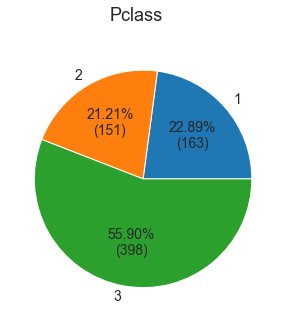

In [26]:
pie_chart(titanic, feature='Pclass', categories=[1, 2, 3])

###### Pclass explained:
As seen from a cell above we do not have any missing data on the Pclass attribute.

We can see that there is an imbalance in the partition according to Pclass and more than half of the passengers are of the 3rd (lowest "socio-economic status" class), the rest of the passengers divide pretty evenly between the first two classes (a slight difference of approximately 10 passengers - about 1.7%).

### Pclass relationship with Survived

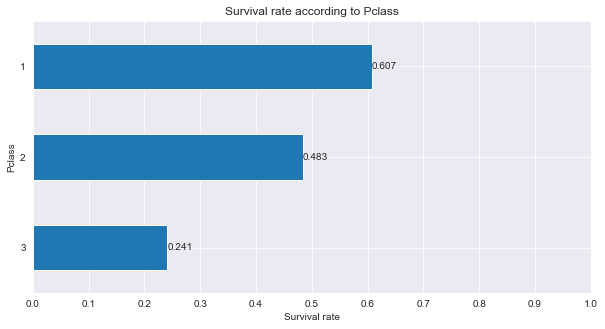

In [27]:
survival_rate_per_category_plot(titanic, feature='Pclass')

Although the majority of the passengers are from the 3rd class we see that the survival rate of this class is the lowest while the survival rate of the 1st class is the highest (roughly 60%).

## Name

In [28]:
def find_honorifics(name: str) -> str:
    honorific_names = r'(?:Mrs|Mr|Ms|Miss|Master|Don|Rev|Mme|Major|Mlle|Col|Capt|Jonkheer|Countess|Dr)\.?'
    honorific = re.findall(honorific_names, name)
    if not honorific:  # empty list - no honorific found
        return 'non_honorific'
    honorific = honorific[0]  # findall returns a list - in our case list of single string
    honorific = honorific.split()[0]  # the string contains the honorific in first place if exists
    honorific = honorific.replace('.', '')
    return honorific

In [29]:
titanic['Honorifics'] = titanic['Name'].apply(lambda name: find_honorifics(name))
# checking if honorific succeeded for all passengers
all_non_honorifics = titanic[titanic['Honorifics'] == 'non_honorific']
all_non_honorifics

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorifics


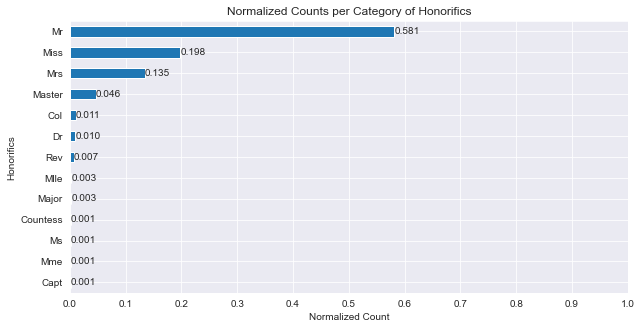

In [30]:
count_plot(titanic, 'Honorifics')

In [31]:
create_df_for_numeric_cateforical(titanic, 'Honorifics')

,Count,Percent
Honorifics,,
Mr,414,0.581461
Miss,141,0.198034
Mrs,96,0.134831
Master,33,0.046348
Col,8,0.011236
Dr,7,0.009831
Rev,5,0.007022
Major,2,0.002809
Mlle,2,0.002809


###### Name\Honorifics explained:
As seen from a cell above we do not have any missing data on the Name attribute.

From the names honorifics we conclude there are more males than females on board. In addition most people's honorifics are of regular ("common") types and not of a noble kind such as Countess. Furthermore, we see that there are some soldiers\veterans on board too, maybe their training could help them survive.

### Name\Honorifics relationship with Survived

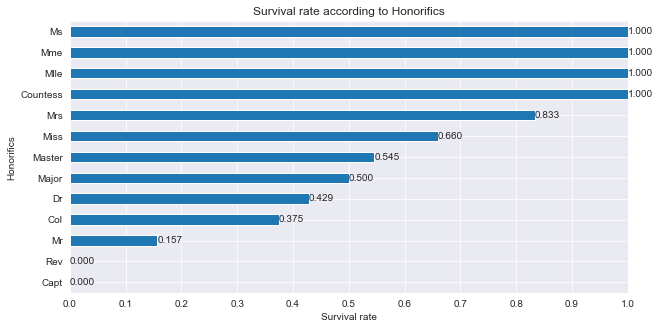

In [32]:
survival_rate_per_category_plot(titanic, 'Honorifics')

We see that veterans\soldiers (besides Capt - 1 passenger which didn't survive), which constitute a small part of the passengers, have pretty high survival rate, and the Major passengers are the second highest rate of male passengers survived. Considering there are only 2, meaning 1 managed to survive (50% survival rate). We conclude that most pf passengers saved are females, and that noble honorifics don't play an important role (although it can influence on Cabin and Pclass which has an impact on survival rate - one Countess passenger who managed to survive). 

## Sex

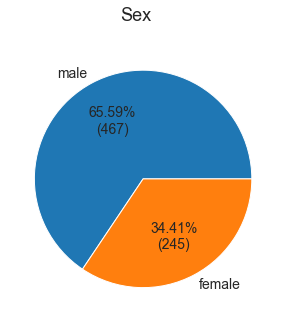

In [33]:
pie_chart(titanic, feature='Sex', categories=["male", "female"])

###### Sex explained:
As seen from a cell above we do not have any missing data on the Sex attribute.

We can see that there is an imbalance in the partition according to Sex and the data is biased to the male category, meaning most of the passengers are males.

### Sex relationship with Survived

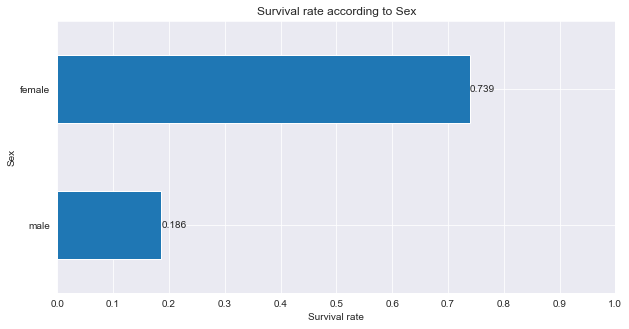

In [34]:
survival_rate_per_category_plot(titanic, 'Sex')

We can see that the majority of passengers who survived are females and probably priority in evacuation is given to them (could be as well to elders and children - given the lack of lifeboats).

## Age

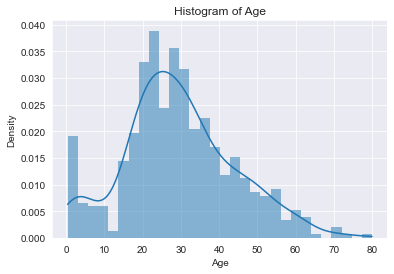

In [35]:
hist_and_kde(titanic, 'Age')

In [36]:
skewness_and_kurtosis(titanic, 'Age')

Skewness: 0.331
Kurtosis: 0.149


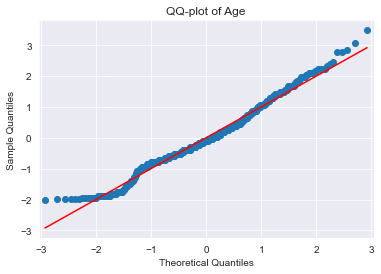

In [37]:
qqplot(titanic, 'Age')

In [38]:
age_normal_tests = normality_tests(titanic, 'Age')
age_normal_tests

,shapiro,normaltest,chisquare
Age,0.000002,0.004599,0.0


The interquartile range: [21.0, 38.0]
The outliers' bounds are: lower bound=-4.500, upper bound=63.500


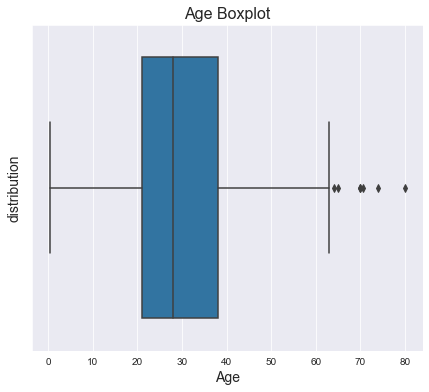

In [39]:
boxplot_and_outliers(titanic, 'Age')

In [40]:
titanic['Age'].describe()  # describe knows how to handle nans

count    572.000000
mean      29.498846
std       14.500059
min        0.420000
25%       21.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

###### Age explained:
As seen from a cell above we have about 20% of missing data on the Age attribute.

From the histogram it's hard to conclude that the distribution is a normal distribution (statistical tests will be done - maybe after imputing will improve), and from the skewnees value we get not so large positive skew, which means the data is skewed to the right by some amount (we have some "outliers" of old passengers). Kurtosis' small positive number indicates the peak of the frequency is slightly higher than that of a normal distribution, which indicates on having a (right) heavy tail, or outliers.

We define outliers as people with Age higher than the upper whisker bound (upper bound=63.5), and lower than the lower whisker (lower bound=-4.5) which isn't physibily so we won't have any in the lower bound since Age is non-negative. From the boxplot we can see that there aren’t any outliers in the lower side of Age (as expected), and in the upper side of Age there are some outliers. The histogram shows that the majority of people is in the Age range of 21-38 (our whiskers range).
It seems that the Age distribution is not very symmetrical (given the lower bound of 0), around the mean value of 29.49. However, we have more points in the right tail than the left tail (more outliers from the upper bound than from the lower bound).

In all the normality tests performed, the null hypothesis is that the data is normally distributed, and alternative hypothesis states the opposite. We get very low p-values from all of the tests performed so we cannot conclude our Age attribute is normally distributed. However, according to the histogram and the QQ-plot it seems that it could be normally distributed and if we had more data we could get higher p-values and accept the null hypothesis.

### Age relationship with Survived

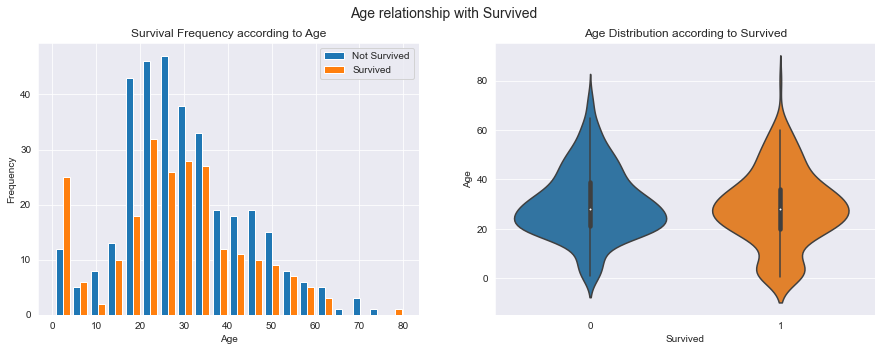

In [41]:
continous_feature_with_survived(titanic, 'Age')

We can see that overall almost in all ages most of the passengers did not survive. For passengers aged below 10 years old (young kids) we get that more survived than not survived meaning that the survival rate is greater than 0.5, and for the smallest bin the number of survived is double greater than those who didn't survive. We also see that the entire biggest bin (oldest passengers) survived. However, the in the bins before that one, the passengers didn't survive at all, could be because of difficulty in evacuating. For old but not elderly passengers the survival rate is quite close to 0.5 from below.

### Age combined with Sex - relationship with Survived 

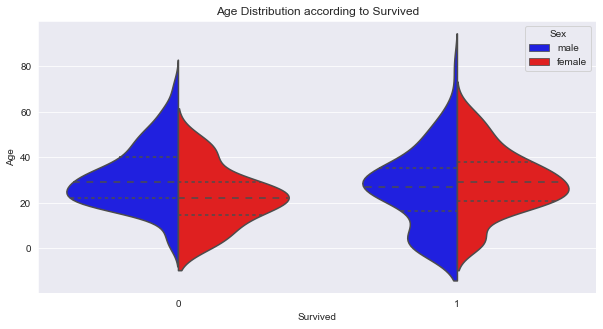

In [42]:
# examining notes of mine - priority to elders, children and women in evacuation
continous_feature_with_survived(titanic, 'Age', hue='Sex', inner='quartile', split=True)

From the violin plot we see that more young men did not survived than those who did, and that it is the opposite for women. For those who didn't survive we see that the median for men is larger than the median for women, also there are old men who didn't survive while there aren't old women who didn't survive. For those who survived the sinking, we see that the age’s median for women is slightly higher than the median for men. We also see that there are more women saved compared to men given the medians and the quartiles are very similar. Furthermore, there are old men who were saved and it could indicate that priority was given to them.

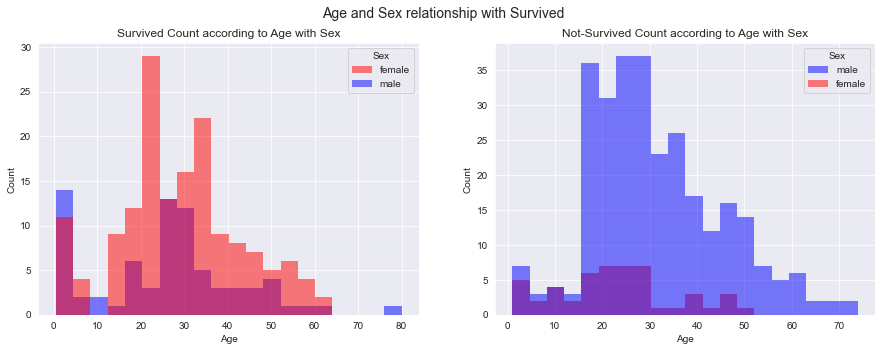

In [43]:
hist_continous_for_survival_of_categorical(titanic, continous_feature='Age', categorical_feature='Sex')

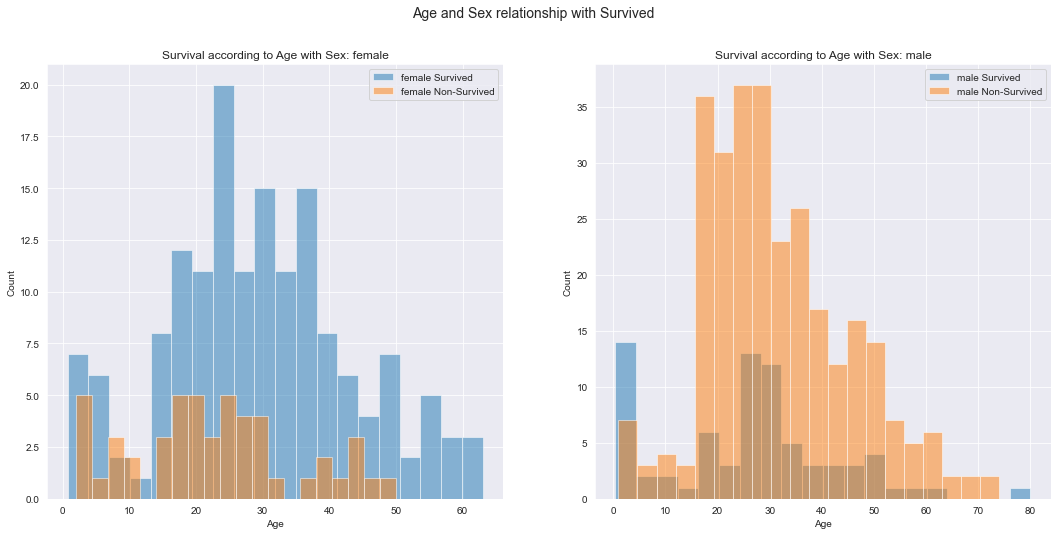

In [44]:
hist_continous_of_categorical_survival(titanic, 'Age', 'Sex')

According to the histograms (mainly from second histogram figure) we get that overall women survived more than not survived while the situation is quite the opposite for men. From the second figure we see that more young women were saved than young men (except for infants where more males were saved).

## SibSp

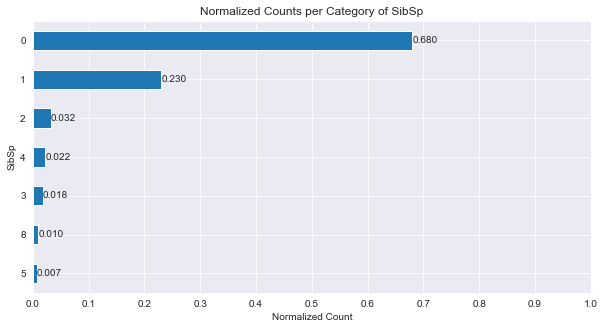

In [45]:
count_plot(titanic, 'SibSp')

In [46]:
count_per_sibsp = create_df_for_numeric_cateforical(titanic, 'SibSp')
count_per_sibsp

,Count,Percent
SibSp,,
0,484,0.679775
1,164,0.230337
2,23,0.032303
4,16,0.022472
3,13,0.018258
8,7,0.009831
5,5,0.007022


In [47]:
print("Passengers with at least one Sibling/Spouse onboard")
count_per_sibsp[1:].sum()

Passengers with at least one Sibling/Spouse onboard


Count      228.000000
Percent      0.320225
dtype: float64

In [48]:
# survived
count_per_sibsp_survived = create_df_for_numeric_cateforical(titanic[titanic['Survived'] == 1], 'SibSp')
print(f"Survived: \n")
display(count_per_sibsp_survived)
print()
print(f"Survived Passengers with at least one Sibling/Spouse onboard: \n{count_per_sibsp_survived[1:].sum()}\n\n")
# non survived
count_per_sibsp_non_survived = create_df_for_numeric_cateforical(titanic[titanic['Survived'] == 0], 'SibSp')
print(f"Non-Survived: \n")
display(count_per_sibsp_non_survived)
print()
print(f"Non-Survived Passengers with at least one Sibling/Spouse onboard: \n{count_per_sibsp_non_survived[1:].sum()}\n")

Survived: 



,Count,Percent
SibSp,,
0,167,0.623134
1,83,0.309701
2,11,0.041045
3,4,0.014925
4,3,0.011194



Survived Passengers with at least one Sibling/Spouse onboard: 
Count      101.000000
Percent      0.376866
dtype: float64


Non-Survived: 



,Count,Percent
SibSp,,
0,317,0.713964
1,81,0.182432
4,13,0.029279
2,12,0.027027
3,9,0.020270
8,7,0.015766
5,5,0.011261



Non-Survived Passengers with at least one Sibling/Spouse onboard: 
Count      127.000000
Percent      0.286036
dtype: float64



The interquartile range: [0.0, 1.0]
The outliers' bounds are: lower bound=-1.500, upper bound=2.500


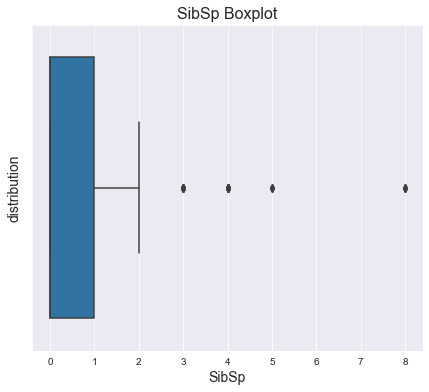

In [49]:
boxplot_and_outliers(titanic, 'SibSp')

###### SibSp explained:
As seen from a cell above we do not have any missing data on the SibSp attribute.

We conclude that most of passengers came with 0 or 1, sibling\spouse. According to boxplot outliers people with more that 2 siblings\spouses is quite unusual.

### SibSp relationship with Survived

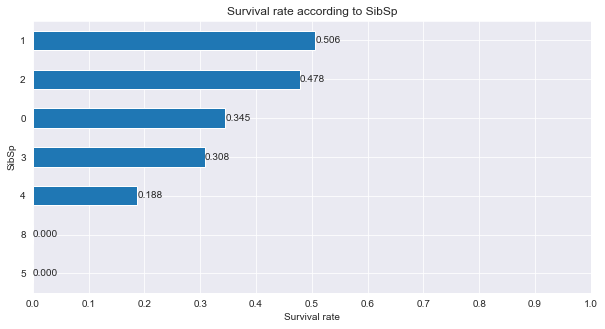

In [50]:
survival_rate_per_category_plot(titanic, feature='SibSp')

- Total: 484 (67.97%) passengers did not have a Sibling/Spouse onboard while 228 (32.03%) passengers had atleast one Sibling/Spouse onboard.

- Survived: 167 (23.45% out of total - 712) passengers did not have any Sibling/Spouse onboard while 101 (14.18%) passengers had atleast one Sibling/Spouse onboard.

- Non-Survived: 317 (44.5%) passengers did not have any Sibling/Spouse onboard while 127 (17.83%) passengers had atleast one Sibling/Spouse onboard.

We see that although the majority of passengers (67.97%) did not have any Sibling/Spouse the survival rate for them is not the highest (34.5%), usually in this case you have just yourself to worry about in evacuation which somehow is in your favour, but we see that does not help in survival.
Maybe when traveling alone you buy a ticket of low class (sharing cabin with other passengers) and it influences in your deck on board which makes it harder to evacuate. In contrast, when traveling with Sibling/Spouse you may take a cabin just for yourselves, of a higher class.

## Parch

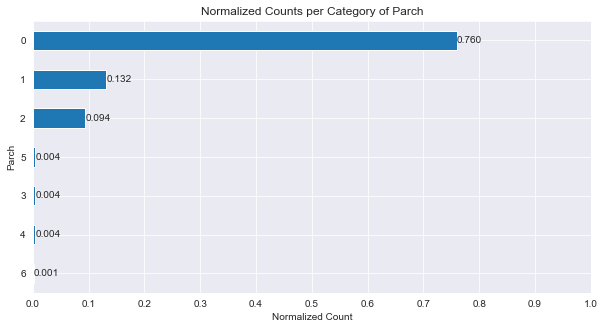

In [51]:
count_plot(titanic, 'Parch')

In [52]:
count_per_parch = create_df_for_numeric_cateforical(titanic, 'Parch')
count_per_parch

,Count,Percent
Parch,,
0,541,0.759831
1,94,0.132022
2,67,0.094101
3,3,0.004213
4,3,0.004213
5,3,0.004213
6,1,0.001404


The interquartile range: [0.0, 0.0]
The outliers' bounds are: lower bound=0.000, upper bound=0.000


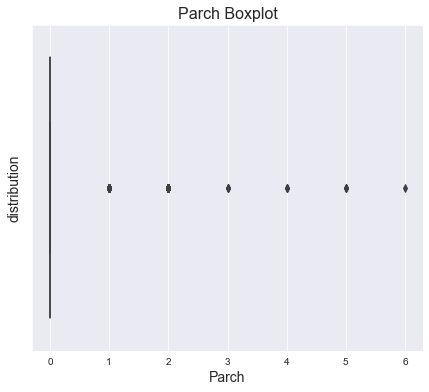

In [53]:
boxplot_and_outliers(titanic, 'Parch')

###### Parch explained:
As seen from a cell above we do not have any missing data on the Parch attribute.

We conclude most of passengers didn't travel with parents or children which fits the Age distribution (most passengers are adults).

### Parch relationship with Survived

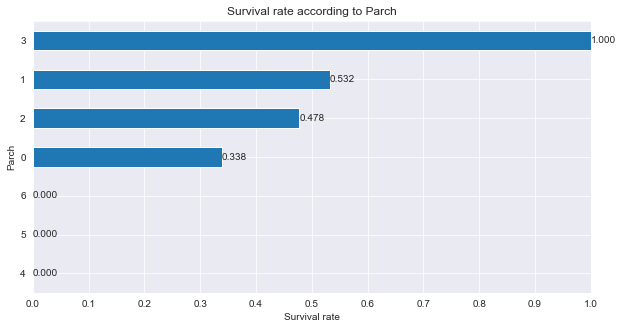

In [54]:
survival_rate_per_category_plot(titanic, feature='Parch')

Although most of the passengers were traveling without parents or children, we get a higher survival rate for the case when traveling with 1 to 3 parents/children and for more we get a 0 survival rate. That could be related to the fact that for families the kids and the wife were saved while just the man did not make it, and when a lot evacuation becomes harder.

### Creating a new feature out of SibSp and Parch - Solo
If both SibSp and Parch are 0 then we say the passenger is by himself on board, meaning he is traveling solo.

In [55]:
titanic['Solo'] = (titanic['Parch'] + titanic['SibSp']).apply(lambda x: 1 if x == 0 else 0)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorifics,Solo
0,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S,Mr,1
1,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S,Mr,1
2,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S,Mr,1
3,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S,Mr,0
4,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,Miss,0


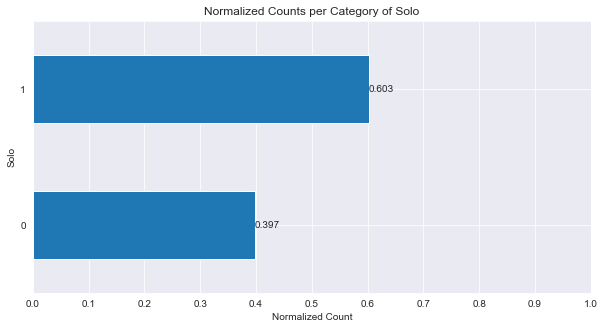

In [56]:
count_plot(titanic, 'Solo')

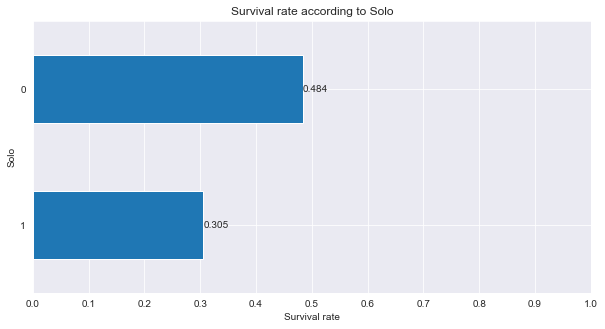

In [57]:
survival_rate_per_category_plot(titanic, feature='Solo')

Although most of the passengers were traveling Solo, we get a higher survival rate for the case when traveling with relatives (SibSp/Parch). That could be related to the fact that for families the kids and the wife were saved while just the man did not make it.

## Ticket

In [58]:
# come back later

## Fare

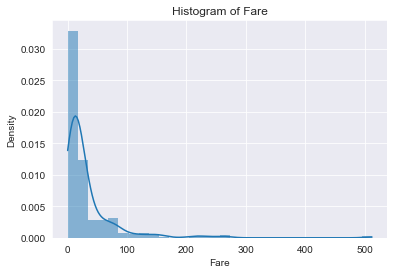

In [59]:
hist_and_kde(titanic, 'Fare')

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


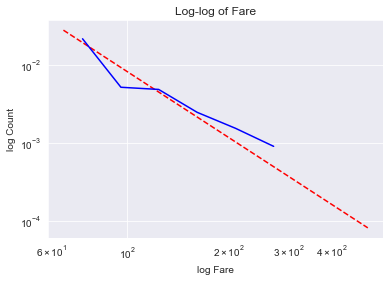

In [60]:
log_log_plot(titanic, 'Fare')

The interquartile range: [7.925, 30.5]
The outliers' bounds are: lower bound=-25.937, upper bound=64.362


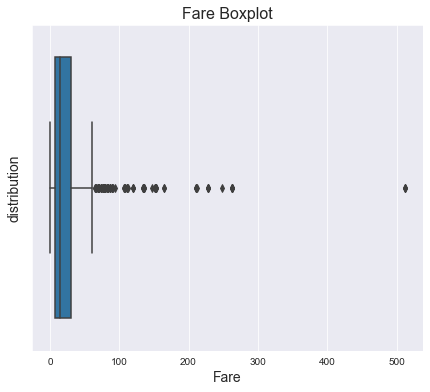

In [61]:
boxplot_and_outliers(titanic, 'Fare')

In [62]:
count_per_fare = create_df_for_numeric_cateforical(titanic, 'Fare')
count_per_fare

,Count,Percent
Fare,,
8.0500,35,0.049157
13.0000,33,0.046348
7.8958,32,0.044944
7.7500,26,0.036517
26.0000,25,0.035112
...,...,...
7.8000,1,0.001404
35.0000,1,0.001404
34.0208,1,0.001404


In [63]:
titanic['Fare'].describe()  # describe knows how to handle nans

count    712.000000
mean      32.586276
std       51.969529
min        0.000000
25%        7.925000
50%       14.454200
75%       30.500000
max      512.329200
Name: Fare, dtype: float64

###### Fare explained:
As seen from a cell above we do not have any missing data on the Fare attribute.

### Fare relationship with Survived

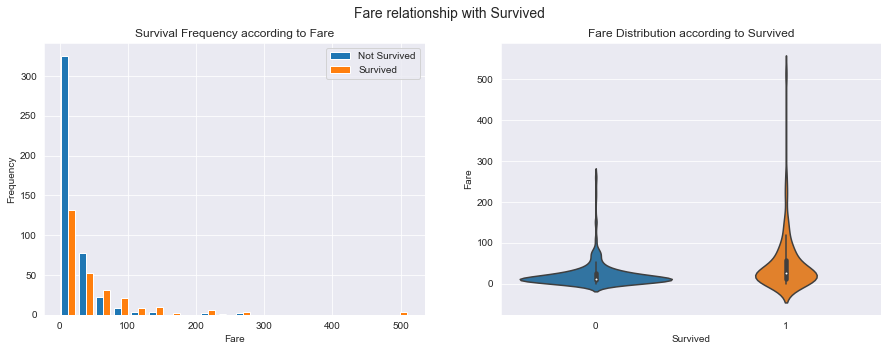

In [64]:
continous_feature_with_survived(titanic, 'Fare')

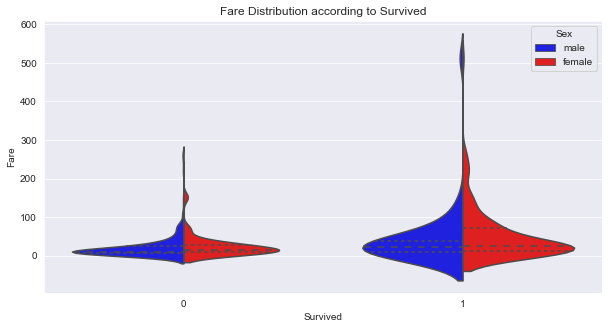

In [65]:
continous_feature_with_survived(titanic, 'Fare', hue='Sex', inner='quartile', split=True)

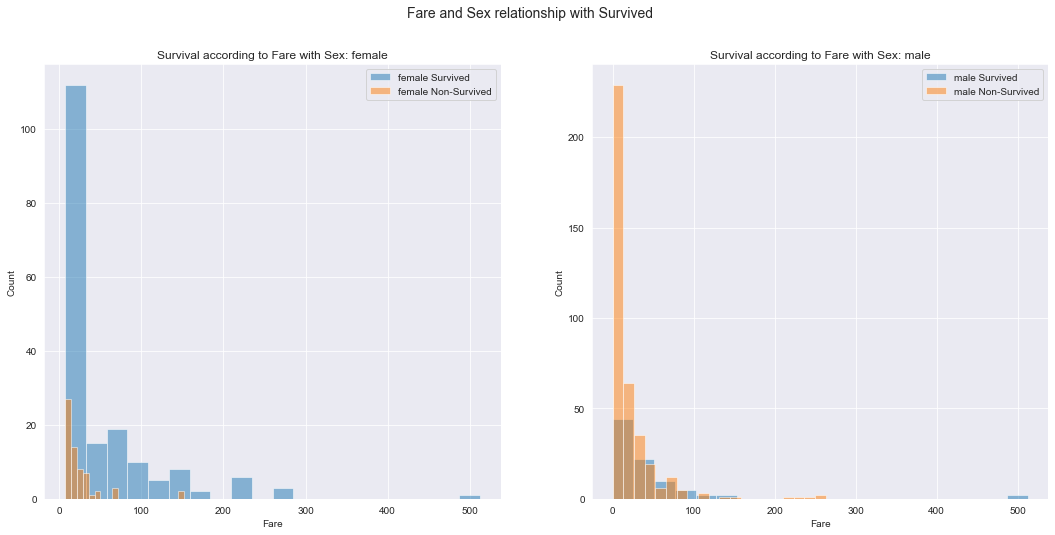

In [66]:
hist_continous_of_categorical_survival(titanic, 'Fare', 'Sex')

## Cabin

In [67]:
unique_cabins = np.unique(titanic['Cabin'].astype(str))
print(f"num of unique_cabins: {len(unique_cabins)} - including NaN")
print(list(unique_cabins))
# display(dict(titanic['Cabin'].value_counts(ascending=True)))

num of unique_cabins: 118 - including NaN
['A10', 'A14', 'A16', 'A19', 'A23', 'A24', 'A26', 'A32', 'A34', 'A36', 'B101', 'B102', 'B18', 'B19', 'B20', 'B22', 'B28', 'B3', 'B35', 'B37', 'B38', 'B4', 'B41', 'B42', 'B49', 'B5', 'B50', 'B51 B53 B55', 'B57 B59 B63 B66', 'B58 B60', 'B71', 'B73', 'B77', 'B79', 'B80', 'B82 B84', 'B94', 'B96 B98', 'C101', 'C103', 'C104', 'C106', 'C111', 'C118', 'C123', 'C124', 'C125', 'C128', 'C2', 'C22 C26', 'C23 C25 C27', 'C30', 'C32', 'C45', 'C46', 'C47', 'C49', 'C50', 'C52', 'C54', 'C62 C64', 'C65', 'C68', 'C7', 'C70', 'C78', 'C82', 'C83', 'C85', 'C86', 'C87', 'C90', 'C91', 'C92', 'C93', 'C99', 'D', 'D11', 'D17', 'D20', 'D26', 'D30', 'D33', 'D35', 'D36', 'D37', 'D45', 'D46', 'D49', 'D56', 'D6', 'D9', 'E10', 'E101', 'E12', 'E121', 'E17', 'E24', 'E31', 'E33', 'E38', 'E40', 'E44', 'E46', 'E50', 'E58', 'E67', 'E8', 'F E69', 'F G63', 'F G73', 'F2', 'F33', 'F38', 'F4', 'G6', 'T', 'nan']


### New feature made CabinChar
Extracting first character from the cabin.

In [68]:
cabins = titanic['Cabin'].astype(str)
cabin_char = [cab[0] for cab in cabins]  # when NaN then char would be 'n'
titanic['CabinChar'] = cabin_char
titanic['CabinChar'].unique()

array(['C', 'n', 'B', 'F', 'D', 'E', 'A', 'G', 'T'], dtype=object)

In [69]:
count_per_cabin_char = create_df_for_numeric_cateforical(titanic, 'CabinChar')
count_per_cabin_char

,Count,Percent
CabinChar,,
n,553,0.776685
C,52,0.073034
B,38,0.053371
E,24,0.033708
D,19,0.026685
F,12,0.016854
A,10,0.014045
G,3,0.004213
T,1,0.001404


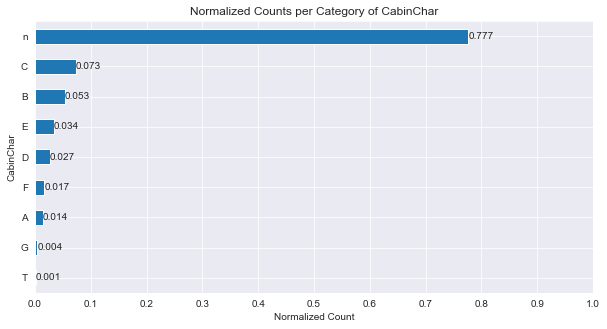

In [70]:
count_plot(titanic, 'CabinChar')

###### Cabin explained:
As seen from a cell above we do have 77% missing data on the Cabin attribute.

### Cabin relationship with Survived

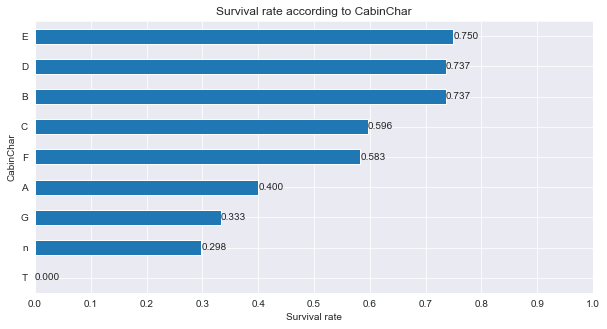

In [71]:
survival_rate_per_category_plot(titanic, feature='CabinChar')

We get that for missing data the survival rate is less than the total survival rate (0.37), so it could be related and used as a feature.

## Embarked

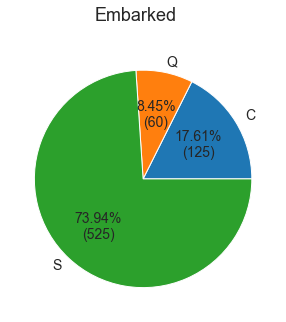

In [72]:
pie_chart(titanic, feature='Embarked', categories=['C', 'Q', 'S'])

###### Embarked explained:
As seen from a cell above we have 2 rows of missing data on the Embarked attribute (0.28%).

The titanic embarked from Southampton, which is where most of the passengers embarked too (73.94%). Its next stop was in Cherbourg and more passengers got on the titanic (17.61%) and at the last port being Queenstown some more passengers joined the ride (8.45%). It makes sense that the most amount of passengers embarked at the starting port of the titanic and as continuing less new passengers are embarking.

### Embarked relationship with Survived

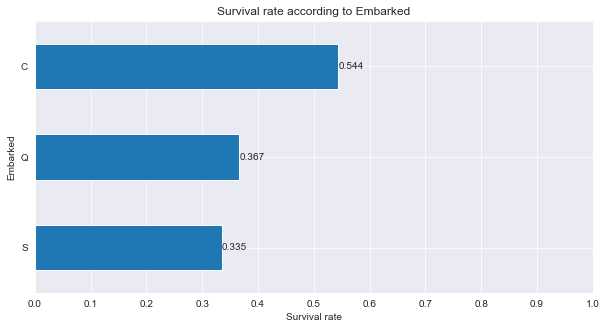

In [73]:
titanic2 = titanic.copy(deep=True)
titanic2['Embarked'] = titanic2['Embarked'].astype(str)
survival_rate_per_category_plot(titanic, 'Embarked')

# 2. Multivariate/Bivariate Analysis

In [74]:
numeric_features = ['Age', 'Fare']

numeric_ordinal_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

categorical_nominal_features = ['Honorifics', 'Sex', 'Embarked', 'CabinChar']  # without Ticket and Cabin (70% null)

categorical_nominal_ordinal_features = ['Pclass', 'SibSp', 'Parch', 'Honorifics', 'Sex', 'Embarked', 'CabinChar']

# sns.pairplot(titanic[numeric_ordinal_features]);

### Multicollinearity: Variance Inflation Factor - VIF

In [75]:
def label_encodings(df: pd.DataFrame, nominal_features: List[str]):
    # dealing with missing data - NaN shouldn't be encoded
    df = df.dropna(subset=nominal_features)
    # encoder
    label_encoder_dict = defaultdict(preprocessing.LabelEncoder)
    # encoding the variables
    df[nominal_features] = df[nominal_features].apply(lambda x: label_encoder_dict[x.name].fit_transform(x))
    return df, label_encoder_dict

In [76]:
def label_decodings(df: pd.DataFrame, nominal_features: List[str], label_encoder_dict: DefaultDict) -> pd.DataFrame:
    # Inverse the encoded
    df[nominal_features] = df[nominal_features].apply(lambda x: label_encoder_dict[x.name].inverse_transform(x))
    return df

In [77]:
# Multicollinearity score - regression made fo each feature based on remained features to check multicollinearity
def calculate_vif(df: pd.DataFrame, features: List[str]) -> pd.DataFrame:    
    vif, tolerance, r2_dict = {}, {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        r2_dict[feature] = r2
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1 / (tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance, 'R_squared': r2_dict})

In [78]:
# making copy for calculating VIF - Variance Inflation Factor (Multicollinearity check)
titanic_vif = titanic.copy(deep=True)
titanic_vif.drop(['PassengerId', 'Ticket', 'Name'], inplace=True, axis=1)
titanic_vif = titanic_vif[titanic_vif['Embarked'].notnull()]  # dropping two missing Embarked rows

titanic_vif, label_encoder_dict = label_encodings(titanic_vif, categorical_nominal_features)
display(titanic_vif)
# categories mappings for each feature
for feature in categorical_nominal_features:
    le = label_encoder_dict[feature]
    print(f"{feature}")
    print(dict(zip(le.classes_, le.transform(le.classes_))))
    print()

# decoding labels in df
# titanic_vif = label_decodings(titanic_vif, categorical_nominal_features, label_encoder_dict)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Honorifics,Solo,CabinChar
0,0,1,1,45.5,0,0,28.5000,C124,2,9,1,2
1,0,2,1,23.0,0,0,13.0000,NaN,2,9,1,8
2,0,3,1,32.0,0,0,7.9250,NaN,2,9,1,8
3,0,3,1,26.0,1,0,7.8542,NaN,2,9,0,8
4,0,3,0,6.0,4,2,31.2750,NaN,2,6,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
707,1,3,0,21.0,0,0,7.6500,NaN,2,6,1,8
708,0,1,1,NaN,0,0,31.0000,NaN,2,9,1,8
709,0,3,1,41.0,2,0,14.1083,NaN,2,9,0,8
710,1,1,0,14.0,1,2,120.0000,B96 B98,2,6,0,1


Honorifics
{'Capt': 0, 'Col': 1, 'Countess': 2, 'Dr': 3, 'Major': 4, 'Master': 5, 'Miss': 6, 'Mlle': 7, 'Mme': 8, 'Mr': 9, 'Mrs': 10, 'Ms': 11, 'Rev': 12}

Sex
{'female': 0, 'male': 1}

Embarked
{'C': 0, 'Q': 1, 'S': 2}

CabinChar
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7, 'n': 8}



In [79]:
titanic_vif_clean_age = titanic_vif.copy(deep=True)
titanic_vif_clean_age = titanic_vif_clean_age[titanic_vif_clean_age['Age'].notnull()]  # dropping NaNs rows from age
# without Cabin
vif_scores_df = calculate_vif(titanic_vif_clean_age, features=numeric_ordinal_features + categorical_nominal_features)
display(vif_scores_df)

,VIF,Tolerance,R_squared
Pclass,2.898912,0.344957,0.655043
Age,1.438905,0.694973,0.305027
SibSp,1.321400,0.756773,0.243227
Parch,1.318180,0.758622,0.241378
Fare,1.694210,0.590245,0.409755
Honorifics,1.193618,0.837789,0.162211
Sex,1.139952,0.877230,0.122770
Embarked,1.117445,0.894899,0.105101
CabinChar,2.529387,0.395353,0.604647


Interpreting VIF Values: 
- 1 — features are not correlated
- 1 < VIF < 5 — features are moderately correlated
- VIF > 5 — features are highly correlated
- VIF > 10 — high correlation between features and is cause for concern

From the result calculating the VIF, we can see the Pclass and CabinChar have VIF values greater than 2.5. This means that Pclass and CabinChar are moderately correlated. This is not surprising as higher Pclass will probably lead to a matching cabin in the class.

In [80]:
categorical_nominal_features_copy = categorical_nominal_features[:]
categorical_nominal_features_copy.remove('CabinChar')

vif_scores_df_without_cabin = \
calculate_vif(titanic_vif_clean_age, features=numeric_ordinal_features + categorical_nominal_features_copy)
display(vif_scores_df_without_cabin)

,VIF,Tolerance,R_squared
Pclass,1.762698,0.567312,0.432688
Age,1.438899,0.694976,0.305024
SibSp,1.319722,0.757735,0.242265
Parch,1.316828,0.759400,0.240600
Fare,1.645257,0.607808,0.392192
Honorifics,1.189569,0.840641,0.159359
Sex,1.139785,0.877359,0.122641
Embarked,1.107889,0.902617,0.097383


We get that Pclass and Fare are moderately correlated too because both have VIF greater than 1.5. This makes sense since a higher Pclass wil lead to higher Fare paid.

Removing CabinChar influenced significantly on Pclass which means they are correlated.

In [81]:
numeric_ordinal_features_copy = numeric_ordinal_features[:]
numeric_ordinal_features_copy.remove('Pclass')

vif_scores_df_without_pclass = \
calculate_vif(titanic_vif_clean_age, features=numeric_ordinal_features_copy + categorical_nominal_features)
display(vif_scores_df_without_pclass)

,VIF,Tolerance,R_squared
Age,1.326142,0.754067,0.245933
SibSp,1.321072,0.756961,0.243039
Parch,1.306635,0.765324,0.234676
Fare,1.544798,0.647334,0.352666
Honorifics,1.191663,0.839163,0.160837
Sex,1.127272,0.887098,0.112902
Embarked,1.117407,0.894929,0.105071
CabinChar,1.538007,0.650192,0.349808


We get that CabinChar and Fare are moderately correlated too because both have VIF greater than 1.5. This makes sense since a cabin chosen wil influence the Fare paid.

Removing Pclass influenced significantly on CabinChar which means they are correlated.

In [82]:
numeric_ordinal_features_copy = numeric_ordinal_features[:]
numeric_ordinal_features_copy.remove('Fare')
numeric_ordinal_features_copy.remove('Pclass')

vif_scores_df_without_high_vif = \
calculate_vif(titanic_vif_clean_age, features=numeric_ordinal_features_copy + categorical_nominal_features)
display(vif_scores_df_without_high_vif)

,VIF,Tolerance,R_squared
Age,1.323769,0.755419,0.244581
SibSp,1.307694,0.764705,0.235295
Parch,1.271831,0.786268,0.213732
Honorifics,1.191570,0.839229,0.160771
Sex,1.123665,0.889945,0.110055
Embarked,1.079097,0.926701,0.073299
CabinChar,1.186632,0.842721,0.157279


After removing both Fare and Pclass we get lower VIF score for CabinChar, meaning these three features are correlated to each other, will be tested using correlation measures for categorical and numerical data.

### Features Correlations to Survived

#### Chi-square test - Categorical Input, Categorical Output
- $H_0$ (Null Hypothesis) — The 2 categorical variables being compared are independent of each other.
- $H_1$ (Alternate Hypothesis) — The 2 categorical variables being compared are dependent on each other.

In [83]:
def categorical_categorical_chi2_test(df: pd.DataFrame, independent_feature: str, dependent_feature: str) -> Tuple[float]:
    contingency_table = pd.crosstab(index=df[independent_feature], columns=df[dependent_feature])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    return chi2_stat, p_value, dof

In [84]:
for feature in categorical_nominal_ordinal_features:
    print(f"{feature}:")
    chi2_stat, p_value, dof = categorical_categorical_chi2_test(titanic, feature, 'Survived')
    print(f"chi2_stat: {chi2_stat}, p_value: {p_value}, degrees of freedom: {dof}\n")

Pclass:
chi2_stat: 75.40595805614943, p_value: 4.224781539411178e-17, degrees of freedom: 2

SibSp:
chi2_stat: 24.734279214618162, p_value: 0.00038237568951122655, degrees of freedom: 6

Parch:
chi2_stat: 25.157000346188546, p_value: 0.0003193372015388348, degrees of freedom: 6

Honorifics:
chi2_stat: 234.59408665561756, p_value: 2.2107779065672057e-43, degrees of freedom: 12

Sex:
chi2_stat: 206.62018441778923, p_value: 7.50366894268402e-47, degrees of freedom: 1

Embarked:
chi2_stat: 18.79846624282714, p_value: 8.278752920243536e-05, degrees of freedom: 2

CabinChar:
chi2_stat: 73.70295936254551, p_value: 8.966593033446099e-13, degrees of freedom: 8



We get for all categorical features (nominal/ordinal) p-values smaller that 0.05 therefore we reject the null hypothesis and accept the alternative hypothesis that the features are dependent with the Survived (target) feature.

#### ANOVA - Numerical Input, Categorical Output
ANOVA is used when the categorical variable has at least 3 groups (i.e three different unique values)
- $H_0$ (Null hypothesis) — There is no difference among group means.
- $H_1$ (Alternate hypothesis) — At least one group differs significantly from the overall mean of the dependent variable.

In [85]:
def numerical_categorical_anova_test(df: pd.DataFrame, independent_feature: str, dependent_feature: str) -> Tuple[float]:
    # independent_feature should be numerical and dependent_feature should be categorical
    df_clean = df[df[feature].notnull()]
    model = ols(f'{independent_feature} ~ {dependent_feature}', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table

In [86]:
numerical_categorical_anova_test(titanic, 'Age', 'Survived')

,sum_sq,df,F,PR(>F)
Survived,427.815632,1.0,2.038479,0.153911
Residual,119625.909207,570.0,NaN,NaN


In [87]:
numerical_categorical_anova_test(titanic, 'Fare', 'Survived')

,sum_sq,df,F,PR(>F)
Survived,1.168146e+05,1.0,45.988025,2.506434e-11
Residual,1.803477e+06,710.0,NaN,NaN


In [88]:
def numerical_categorical_kendall(df: pd.DataFrame, independent_feature: str, dependent_feature: str) -> Tuple[float]:
    df_clean = df[df[independent_feature].notnull()]
    tau, p_value = stats.kendalltau(df_clean[independent_feature], df_clean[dependent_feature])
    return tau, p_value

In [89]:
for feature in numeric_ordinal_features:
    print(f"{feature}:")
    tau, p_value = numerical_categorical_kendall(titanic, feature, 'Survived')
    print(f"tau: {tau}, p_value: {p_value}\n")

Pclass:
tau: -0.31002636286561597, p_value: 4.124242956905521e-18

Age:
tau: -0.030229200683216773, p_value: 0.3816041278090925

SibSp:
tau: 0.0666997601453263, p_value: 0.06516186126467635

Parch:
tau: 0.1279779459364076, p_value: 0.0004288371801645157

Fare:
tau: 0.2446019722261931, p_value: 2.208443078757529e-15



### Heatmap: Features Correlations (including target)

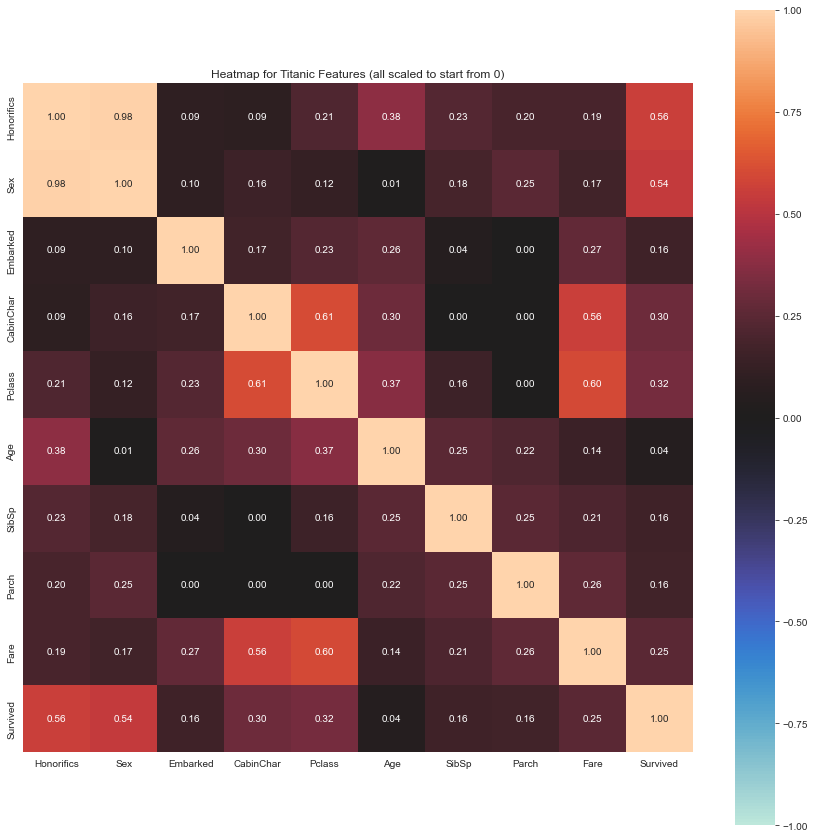

In [90]:
fig, ax = plt.subplots(figsize=(15, 15))
features_for_heatmap = categorical_nominal_features + numeric_ordinal_features + ['Survived']
associations(titanic[features_for_heatmap], nominal_columns=categorical_nominal_ordinal_features + ['Survived'], 
             numerical_columns=numeric_features, vmin=0, ax=ax, 
             title='Heatmap for Titanic Features (all scaled to start from 0)');

# 3. Dealing with Missing Data: Data Imputation

In [91]:
# removing 2 rows of missing data of the Embarked feature
titanic = titanic[titanic['Embarked'].notnull()]

# Features for when we have missing data
titanic['AgeNaN'] = np.where(titanic['Age'].isnull(), 1, 0)
titanic['CabinNaN'] = np.where(titanic['Cabin'].isnull(), 1, 0)

titanic.drop(['Name', 'Cabin'], axis=1, inplace=True)  # not dropping PassengerId - used for plots
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Honorifics,Solo,CabinChar,AgeNaN,CabinNaN
0,332,0,1,male,45.5,0,0,113043,28.5000,S,Mr,1,C,0,0
1,734,0,2,male,23.0,0,0,28425,13.0000,S,Mr,1,n,0,1
2,383,0,3,male,32.0,0,0,STON/O 2. 3101293,7.9250,S,Mr,1,n,0,1
3,705,0,3,male,26.0,1,0,350025,7.8542,S,Mr,0,n,0,1
4,814,0,3,female,6.0,4,2,347082,31.2750,S,Miss,0,n,0,1


### Imputing Age

In [92]:
features_to_use_impute_age = features.copy()
features_to_use_impute_age.remove('Ticket')
features_to_use_impute_age.remove('Name')
features_to_use_impute_age.remove('Cabin')
features_to_use_impute_age.append('Honorifics')
features_to_use_impute_age

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Honorifics']

In [93]:
def mice_numerical_features(df: pd.DataFrame, features_to_use_impute: List[str], 
                            nominal_ordinal_features: List[str]) -> pd.DataFrame:
    # imputing missing data for numerical features using mice approach - Multiple Imputation by Chained Equations
    # df should contain categorical features that have had their labels encoded already
    lr = LinearRegression()
    imp = IterativeImputer(estimator=lr, missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman', \
                           random_state=0)

    # important - without target variable
    X = df[features_to_use_impute].values
    # fitting and transforming imputation model
    imp.fit(X)
    X = imp.transform(X)
    # setting the imputed data to the dataframe
    df[features_to_use_impute] = X
    # converting back nominal and ordinal features to be ints after imputation made them floats
    df[nominal_ordinal_features] = df[nominal_ordinal_features].astype(int)
    return df

In [94]:
titanic_vif_copy = titanic_vif.copy(deep=True)
titanic_vif_copy = mice_numerical_features(titanic_vif_copy, features_to_use_impute_age, 
                                           categorical_nominal_ordinal_features)
print()
print(f"Is all data on Age was imputed properly? {titanic_vif_copy[titanic_vif_copy['Age'].isnull()].empty}")
display(titanic_vif_copy)

[IterativeImputer] Completing matrix with shape (710, 8)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.02
[IterativeImputer] Change: 35.323211123357396, scaled tolerance: 0.5123292 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.02
[IterativeImputer] Change: 0.0, scaled tolerance: 0.5123292 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (710, 8)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.00

Is all data on Age was imputed properly? True


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Honorifics,Solo,CabinChar
0,0,1,1,45.500000,0,0,28.5000,C124,2,9,1,2
1,0,2,1,23.000000,0,0,13.0000,NaN,2,9,1,8
2,0,3,1,32.000000,0,0,7.9250,NaN,2,9,1,8
3,0,3,1,26.000000,1,0,7.8542,NaN,2,9,0,8
4,0,3,0,6.000000,4,2,31.2750,NaN,2,6,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
707,1,3,0,21.000000,0,0,7.6500,NaN,2,6,1,8
708,0,1,1,43.178817,0,0,31.0000,NaN,2,9,1,8
709,0,3,1,41.000000,2,0,14.1083,NaN,2,9,0,8
710,1,1,0,14.000000,1,2,120.0000,B96 B98,2,6,0,1


In [95]:
titanic

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Honorifics,Solo,CabinChar,AgeNaN,CabinNaN
0,332,0,1,male,45.5,0,0,113043,28.5000,S,Mr,1,C,0,0
1,734,0,2,male,23.0,0,0,28425,13.0000,S,Mr,1,n,0,1
2,383,0,3,male,32.0,0,0,STON/O 2. 3101293,7.9250,S,Mr,1,n,0,1
3,705,0,3,male,26.0,1,0,350025,7.8542,S,Mr,0,n,0,1
4,814,0,3,female,6.0,4,2,347082,31.2750,S,Miss,0,n,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,107,1,3,female,21.0,0,0,343120,7.6500,S,Miss,1,n,0,1
708,271,0,1,male,NaN,0,0,113798,31.0000,S,Mr,1,n,1,1
709,861,0,3,male,41.0,2,0,350026,14.1083,S,Mr,0,n,0,1
710,436,1,1,female,14.0,1,2,113760,120.0000,S,Miss,0,B,0,0


In [96]:
# titanic['Age'] = titanic_vif_copy['Age']
titanic

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Honorifics,Solo,CabinChar,AgeNaN,CabinNaN
0,332,0,1,male,45.5,0,0,113043,28.5000,S,Mr,1,C,0,0
1,734,0,2,male,23.0,0,0,28425,13.0000,S,Mr,1,n,0,1
2,383,0,3,male,32.0,0,0,STON/O 2. 3101293,7.9250,S,Mr,1,n,0,1
3,705,0,3,male,26.0,1,0,350025,7.8542,S,Mr,0,n,0,1
4,814,0,3,female,6.0,4,2,347082,31.2750,S,Miss,0,n,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,107,1,3,female,21.0,0,0,343120,7.6500,S,Miss,1,n,0,1
708,271,0,1,male,NaN,0,0,113798,31.0000,S,Mr,1,n,1,1
709,861,0,3,male,41.0,2,0,350026,14.1083,S,Mr,0,n,0,1
710,436,1,1,female,14.0,1,2,113760,120.0000,S,Miss,0,B,0,0


# 4. Feature Engineering

### New feature for missing data - Age and Cabin

In [97]:
# done in first cell of part 3. - dropping Name and Cabin columns
## Log transformation on Age didn't work well, larger skewness and kurtosis + normality tests and qqplot worse
### Left to drop PassengerId column that was still used for plots, will be dropped after dealing with Ticket

### Dealing with Ticket feature

In [98]:
ticket_counts_dict = titanic['Ticket'].value_counts().to_dict()
print(f"Counts of top 5 tickets: {list(itertools.islice(ticket_counts_dict.items(), 5))}")
titanic['TicketGroup'] = titanic['Ticket'].apply(lambda x: 1 if ticket_counts_dict[x] > 1 else 0)
titanic.head()

Counts of top 5 tickets: [('CA. 2343', 7), ('347082', 6), ('1601', 6), ('CA 2144', 6), ('3101295', 5)]


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Honorifics,Solo,CabinChar,AgeNaN,CabinNaN,TicketGroup
0,332,0,1,male,45.5,0,0,113043,28.5000,S,Mr,1,C,0,0,0
1,734,0,2,male,23.0,0,0,28425,13.0000,S,Mr,1,n,0,1,0
2,383,0,3,male,32.0,0,0,STON/O 2. 3101293,7.9250,S,Mr,1,n,0,1,0
3,705,0,3,male,26.0,1,0,350025,7.8542,S,Mr,0,n,0,1,0
4,814,0,3,female,6.0,4,2,347082,31.2750,S,Miss,0,n,0,1,1


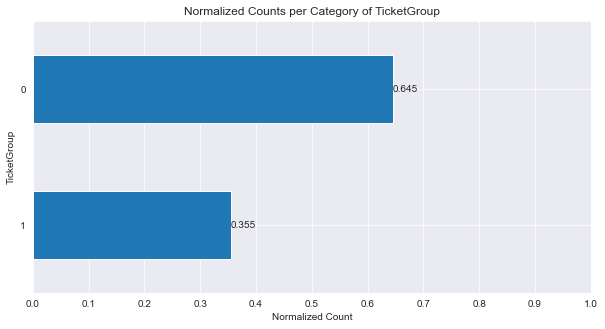

In [99]:
count_plot(titanic, 'TicketGroup')

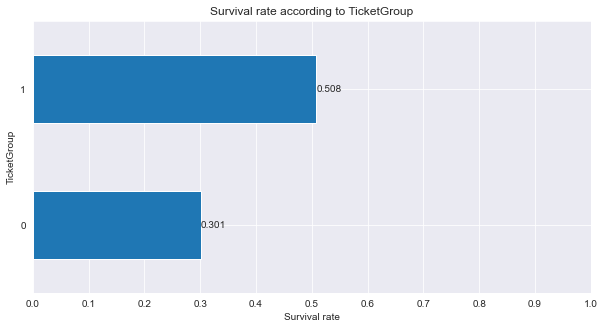

In [100]:
survival_rate_per_category_plot(titanic, feature='TicketGroup')

In [101]:
titanic['GroupSize'] = titanic['Ticket'].map(ticket_counts_dict)
titanic.drop(['Ticket'], axis=1, inplace=True)
titanic

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Honorifics,Solo,CabinChar,AgeNaN,CabinNaN,TicketGroup,GroupSize
0,332,0,1,male,45.5,0,0,28.5000,S,Mr,1,C,0,0,0,1
1,734,0,2,male,23.0,0,0,13.0000,S,Mr,1,n,0,1,0,1
2,383,0,3,male,32.0,0,0,7.9250,S,Mr,1,n,0,1,0,1
3,705,0,3,male,26.0,1,0,7.8542,S,Mr,0,n,0,1,0,1
4,814,0,3,female,6.0,4,2,31.2750,S,Miss,0,n,0,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,107,1,3,female,21.0,0,0,7.6500,S,Miss,1,n,0,1,0,1
708,271,0,1,male,NaN,0,0,31.0000,S,Mr,1,n,1,1,0,1
709,861,0,3,male,41.0,2,0,14.1083,S,Mr,0,n,0,1,0,1
710,436,1,1,female,14.0,1,2,120.0000,S,Miss,0,B,0,0,1,3


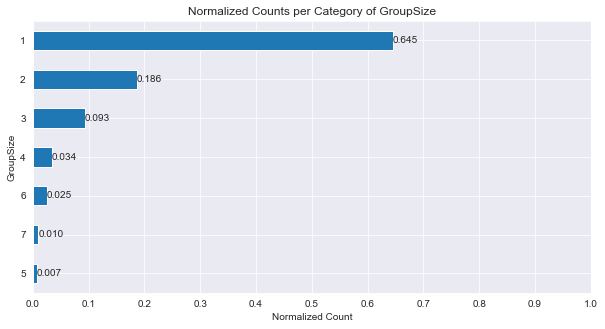

In [102]:
count_plot(titanic, 'GroupSize')

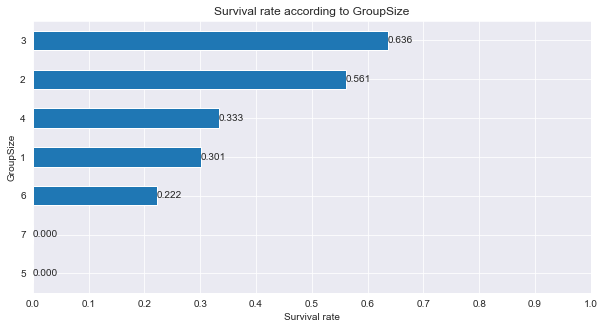

In [103]:
survival_rate_per_category_plot(titanic, feature='GroupSize')

Could be that for groups of 3, we have 2 adults, man and woman, traveling with their child. That could explain the survival rate which is 2/3, because it is likely that the woman and the child survived while the man didn't.

### Dropping PassengerId column

In [104]:
titanic.drop(['PassengerId'], axis=1, inplace=True)

In [105]:
titanic.dtypes

Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
Honorifics      object
Solo             int64
CabinChar       object
AgeNaN           int32
CabinNaN         int32
TicketGroup      int64
GroupSize        int64
dtype: object

# 5. Feature Selection + Engineering (interactions)

In [106]:
train_cols = list(titanic.columns)
train_cols.remove('Survived')
y_col = 'Survived'
train_cols

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked',
 'Honorifics',
 'Solo',
 'CabinChar',
 'AgeNaN',
 'CabinNaN',
 'TicketGroup',
 'GroupSize']

### Logistic Regression

#### KDD orange 1-hot encoding - combining rare categories to one category

In [107]:
def replace_rare_categories(df: pd.DataFrame, feature: str, value_threshold: int, 
                            numeric_replace: bool=True) -> pd.DataFrame:
    replacement = 'RareVal'
    if numeric_replace:
        df_rare = df[df[feature] > value_threshold]
        replacement = df_rare[feature].mean()
        replacement = int(replacement + 1)
    
    df[feature] = np.where(df[feature] <= value_threshold, df[feature], replacement)
    return df

In [108]:
titanic_logistic = titanic.copy(deep=True)
# titanic_logistic = replace_rare_categories(titanic_logistic, 'SibSp', value_threshold=2, numeric_replace=True)
# titanic_logistic = replace_rare_categories(titanic_logistic, 'Parch', value_threshold=2, numeric_replace=True)
y = titanic_logistic['Survived']
titanic_logistic.drop(['Survived'], axis=1, inplace=True)
titanic_logistic.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Honorifics,Solo,CabinChar,AgeNaN,CabinNaN,TicketGroup,GroupSize
0,1,male,45.5,0,0,28.5000,S,Mr,1,C,0,0,0,1
1,2,male,23.0,0,0,13.0000,S,Mr,1,n,0,1,0,1
2,3,male,32.0,0,0,7.9250,S,Mr,1,n,0,1,0,1
3,3,male,26.0,1,0,7.8542,S,Mr,0,n,0,1,0,1
4,3,female,6.0,4,2,31.2750,S,Miss,0,n,0,1,1,6
5,1,male,24.0,0,1,247.5208,C,Mr,0,B,0,0,0,1
6,1,male,45.0,0,0,26.5500,S,Major,1,B,0,0,0,1
7,2,male,29.0,1,0,27.7208,C,Mr,0,n,0,1,0,1
8,3,male,NaN,0,0,7.8958,S,Mr,1,n,1,1,0,1
9,1,male,NaN,0,0,35.5000,S,Mr,1,C,1,0,0,1


#### One hot encoding nominal categorical variables

In [109]:
# using pandas to encode
# titanic_logistic = pd.get_dummies(titanic_logistic, columns=['Honorifics', 'Embarked', 'CabinChar'])
# titanic_logistic, sex_encoder_dict = label_encodings(titanic_logistic, ['Sex'])
# x_covariates = list(titanic_logistic.columns)
# print(np.array(x_covariates))
# print(f"Number of features: {len(x_covariates)}")
# display(titanic_logistic.head(10))

In [110]:
# using sklearn pipeline to encode amd impute

non_transformed = ['Pclass', 'SibSp', 'Parch', 'Fare', 'TicketGroup', 'GroupSize', 'Solo', 'AgeNaN', 'CabinNaN']

label_encoder_features = ["Sex"]
label_encoder_transformer = preprocessing.OrdinalEncoder()

one_hot_features = ["Embarked", "Honorifics", "CabinChar"]
one_hot_transformer = preprocessing.OneHotEncoder(handle_unknown="ignore")

numeric_features = ["Age"]
numeric_transformer = Pipeline(
    steps=[("imputer", IterativeImputer(estimator=LinearRegression(), missing_values=np.nan, max_iter=10, verbose=2, \
                                        imputation_order='roman', random_state=0))]
)


# interaction_features = list(titanic.columns)  # should be without Survived
# interaction_transformer = Pipeline(
#     steps=[("interactor", preprocessing.PolynomialFeatures(include_bias=False, interaction_only=True))]

# )

preprocessor = ColumnTransformer(
    transformers=[
        ("label_encoder", label_encoder_transformer, label_encoder_features),
        ("onehot", one_hot_transformer, one_hot_features),
        ("numeric", numeric_transformer, numeric_features),
    ]
)

# pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
#                            ('poly',preprocessing.PolynomialFeatures(include_bias=False, interaction_only=True))])
# pipeline.fit(titanic)
preprocessor.fit(titanic_logistic)

ColumnTransformer(transformers=[('label_encoder', OrdinalEncoder(), ['Sex']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Embarked', 'Honorifics', 'CabinChar']),
                                ('numeric',
                                 Pipeline(steps=[('imputer',
                                                  IterativeImputer(estimator=LinearRegression(),
                                                                   imputation_order='roman',
                                                                   random_state=0,
                                                                   verbose=2))]),
                                 ['Age'])])

In [111]:
# transformed data does not include non transformed features - shape (710, 27) should be (710, 36)
X = preprocessor.transform(titanic_logistic)
X = X.todense()

# getting all features names included new ones
label_new_features = label_encoder_features
one_hot_new_features = preprocessor.transformers_[1][1].get_feature_names_out()  # pipeline.named_steps['preprocessor']
numeric_new_features = numeric_features
columns_preprocess = list(label_new_features) + list(one_hot_new_features) + list(numeric_new_features)

# assigning transformed data to df (will make new columns)
titanic_logistic[columns_preprocess] = X
titanic_logistic.drop(one_hot_features, axis=1, inplace=True)
titanic_logistic

,Pclass,Sex,Age,SibSp,Parch,Fare,Solo,AgeNaN,CabinNaN,TicketGroup,...,Honorifics_Rev,CabinChar_A,CabinChar_B,CabinChar_C,CabinChar_D,CabinChar_E,CabinChar_F,CabinChar_G,CabinChar_T,CabinChar_n
0,1,1.0,45.500000,0,0,28.5000,1,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,23.000000,0,0,13.0000,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,1.0,32.000000,0,0,7.9250,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,1.0,26.000000,1,0,7.8542,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3,0.0,6.000000,4,2,31.2750,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,3,0.0,21.000000,0,0,7.6500,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
708,1,1.0,29.426912,0,0,31.0000,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
709,3,1.0,41.000000,2,0,14.1083,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
710,1,0.0,14.000000,1,2,120.0000,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
poly = preprocessing.PolynomialFeatures(include_bias=False, interaction_only=True)
data = poly.fit_transform(titanic_logistic)
print(data)
print(data.shape)

[[ 1.   1.  45.5 ...  0.   0.   0. ]
 [ 2.   1.  23.  ...  0.   0.   0. ]
 [ 3.   1.  32.  ...  0.   0.   0. ]
 ...
 [ 3.   1.  41.  ...  0.   0.   0. ]
 [ 1.   0.  14.  ...  0.   0.   0. ]
 [ 1.   1.  21.  ...  0.   0.   0. ]]
(710, 666)


In [113]:
columns_interactions = poly.get_feature_names_out(titanic_logistic.columns)
titanic_logistic[columns_interactions] = data
titanic_logistic = titanic_logistic.loc[:, (titanic_logistic != 0).any(axis=0)]  # removing columns with only zeros
titanic_logistic

,Pclass,Sex,Age,SibSp,Parch,Fare,Solo,AgeNaN,CabinNaN,TicketGroup,...,Honorifics_Mrs CabinChar_A,Honorifics_Mrs CabinChar_B,Honorifics_Mrs CabinChar_C,Honorifics_Mrs CabinChar_D,Honorifics_Mrs CabinChar_E,Honorifics_Mrs CabinChar_F,Honorifics_Mrs CabinChar_G,Honorifics_Mrs CabinChar_n,Honorifics_Ms CabinChar_n,Honorifics_Rev CabinChar_n
0,1.0,1.0,45.500000,0.0,0.0,28.5000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,23.000000,0.0,0.0,13.0000,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,32.000000,0.0,0.0,7.9250,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1.0,26.000000,1.0,0.0,7.8542,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,6.000000,4.0,2.0,31.2750,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,3.0,0.0,21.000000,0.0,0.0,7.6500,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
708,1.0,1.0,29.426912,0.0,0.0,31.0000,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
709,3.0,1.0,41.000000,2.0,0.0,14.1083,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
710,1.0,0.0,14.000000,1.0,2.0,120.0000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
# performing feature selection
from sklearn.feature_selection import RFECV
clf_featr_sele = LogisticRegression()
min_features_to_select = 1
rfecv = RFECV(estimator=clf_featr_sele, step=1, cv=5, scoring='roc_auc')
pipeline  = Pipeline([('feature_sele', rfecv)])

pipeline.fit(titanic_logistic, y)

Pipeline(steps=[('feature_sele',
                 RFECV(cv=5, estimator=LogisticRegression(),
                       scoring='roc_auc'))])

In [115]:
selected_bool = pipeline.named_steps['feature_sele'].support_
all_features = np.array(titanic_logistic.columns)
selected_features = all_features[selected_bool]
print(len(selected_features))
print(selected_features)

303
['Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Solo' 'AgeNaN' 'TicketGroup'
 'GroupSize' 'Embarked_C' 'Embarked_Q' 'Embarked_S' 'Honorifics_Capt'
 'Honorifics_Master' 'Honorifics_Miss' 'Honorifics_Mr' 'Honorifics_Mrs'
 'Honorifics_Ms' 'Honorifics_Rev' 'CabinChar_A' 'CabinChar_C'
 'CabinChar_D' 'CabinChar_E' 'CabinChar_F' 'CabinChar_G' 'Pclass Sex'
 'Pclass Age' 'Pclass SibSp' 'Pclass Parch' 'Pclass Fare' 'Pclass Solo'
 'Pclass AgeNaN' 'Pclass CabinNaN' 'Pclass GroupSize' 'Pclass Embarked_C'
 'Pclass Embarked_Q' 'Pclass Embarked_S' 'Pclass Honorifics_Capt'
 'Pclass Honorifics_Dr' 'Pclass Honorifics_Master'
 'Pclass Honorifics_Miss' 'Pclass Honorifics_Mr' 'Pclass Honorifics_Mrs'
 'Pclass Honorifics_Ms' 'Pclass Honorifics_Rev' 'Pclass CabinChar_A'
 'Pclass CabinChar_C' 'Pclass CabinChar_D' 'Pclass CabinChar_E'
 'Pclass CabinChar_F' 'Pclass CabinChar_G' 'Pclass CabinChar_n' 'Sex Age'
 'Sex SibSp' 'Sex Parch' 'Sex Fare' 'Sex Solo' 'Sex AgeNaN' 'Sex CabinNaN'
 'Sex TicketGroup' 'Sex GroupSize' 'Se

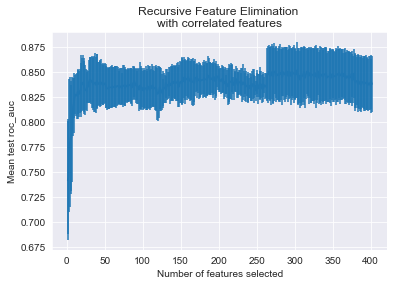

In [116]:
n_scores = len(pipeline.named_steps['feature_sele'].cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test roc_auc")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    pipeline.named_steps['feature_sele'].cv_results_["mean_test_score"],
    yerr=pipeline.named_steps['feature_sele'].cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Features' Importances

### Tree Model

In [117]:
train, val = train_test_split(titanic, test_size=0.2, random_state=42)
print('Train')
display(train.head())
print()
print('Val')
display(val.head())

Train


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Honorifics,Solo,CabinChar,AgeNaN,CabinNaN,TicketGroup,GroupSize
312,0,3,male,32.0,0,0,7.7500,Q,Mr,1,n,0,1,0,1
586,0,3,male,20.0,0,0,4.0125,C,Mr,1,n,0,1,0,1
24,1,3,female,63.0,0,0,9.5875,S,Mrs,1,n,0,1,0,1
160,0,2,male,52.0,0,0,13.5000,S,Mr,1,n,0,1,0,1
552,0,3,male,NaN,0,0,8.0500,S,Mr,1,n,1,1,0,1



Val


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Honorifics,Solo,CabinChar,AgeNaN,CabinNaN,TicketGroup,GroupSize
296,1,1,female,33.0,1,0,53.1000,S,Mrs,0,E,0,0,1,2
258,0,3,male,NaN,0,0,7.8958,S,Mr,1,n,1,1,0,1
704,0,2,male,35.0,0,0,26.0000,S,Mr,1,n,0,1,1,2
359,1,2,male,NaN,0,0,13.0000,S,Mr,1,n,1,1,0,1
250,1,2,female,45.0,1,1,26.2500,S,Mrs,0,n,0,1,1,3


In [118]:
train_xgb = train.copy(deep=True)
val_xgb = val.copy(deep=True)

train_xgb[categorical_nominal_features] = train_xgb[categorical_nominal_features].astype("category")
val_xgb[categorical_nominal_features] = val_xgb[categorical_nominal_features].astype("category")

X_train_xgb = train_xgb[train_cols]
y_train_xgb = train_xgb[y_col]

X_val_xgb = val_xgb[train_cols]
y_val_xgb = val_xgb[y_col]

dtrain = xgb.DMatrix(X_train_xgb, y_train_xgb, feature_names=train_cols, enable_categorical=True)
dval = xgb.DMatrix(X_val_xgb, y_val_xgb, feature_names=train_cols, enable_categorical=True)

### Running XGBoost to get initial feature importances

In [119]:
params = {'tree_method': 'hist',
 'silent': 1,
 'colsample_bytree': 0.8999504397295506,
 'subsample': 0.7446134812140273,
 'learning_rate': 0.05,
 'max_leaves': 72,
 'objective': 'binary:logistic',
 'max_depth': 0,
 'reg_alpha': 0.7726783188295172,
 'min_child_weight': 2,
 'eval_metric': 'auc',
 'grow_policy':'lossguide'}

In [120]:
clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=1500, evals=[(dtrain, "Train"), (dval, "Val")], 
                verbose_eval= 250, early_stopping_rounds=100)

[16:17:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	Train-auc:0.84804	Val-auc:0.34416
[108]	Train-auc:0.95354	Val-auc:0.67852


XGBoost feature importance types:
- "weight" is the number of times a feature appears in a tree
- "gain" is the average gain of splits which use the feature
- "cover" is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

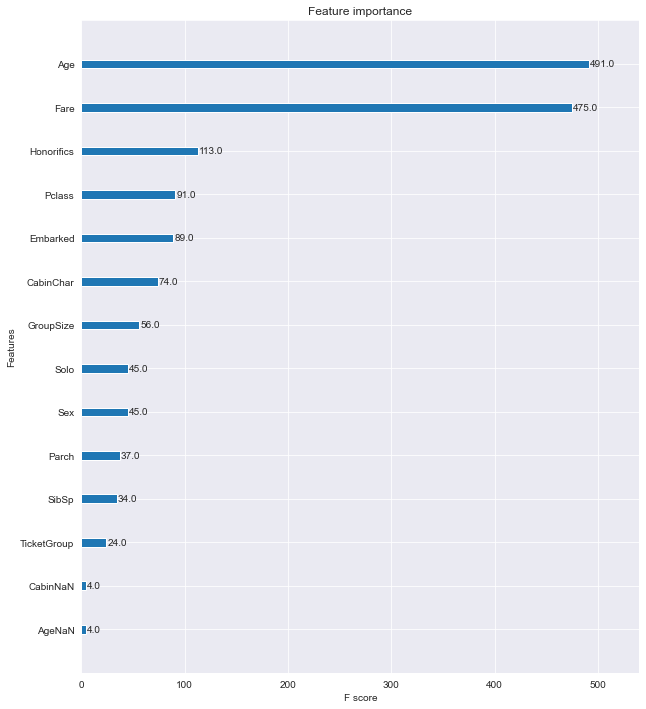

In [121]:
# weight
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Cover', ylabel='Features'>

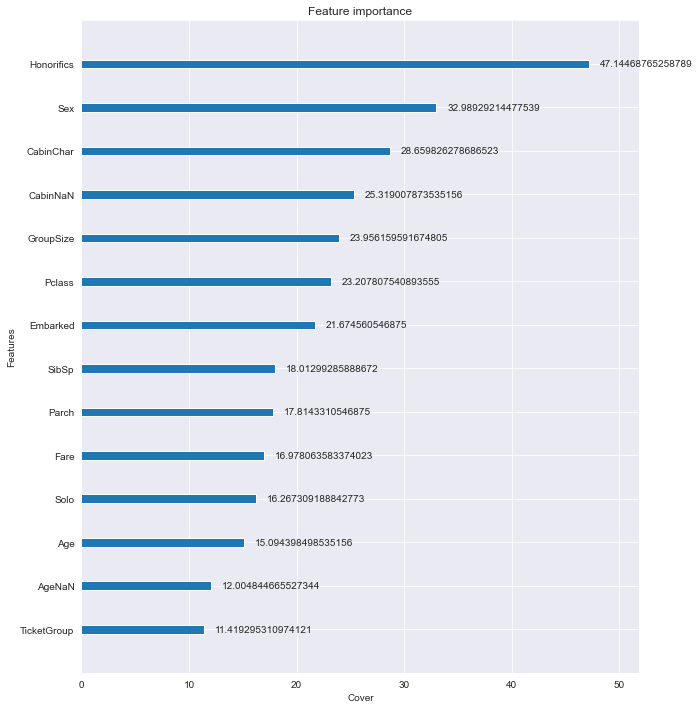

In [122]:
# cover
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax, importance_type="cover", xlabel="Cover")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Gain', ylabel='Features'>

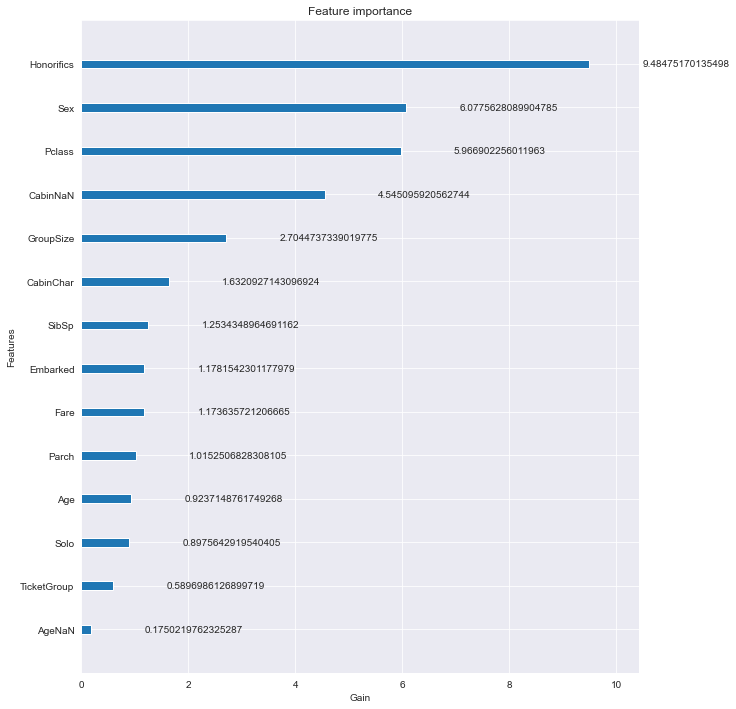

In [123]:
# gain
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax, importance_type="gain", xlabel="Gain")

### Running XGBoost to on selected features

In [124]:
titanic_logistic = titanic_logistic[selected_features]
X_train, X_val, y_train, y_val = train_test_split(titanic_logistic, y, test_size=0.2, random_state=42)
print('Train')
display(X_train.head())
print()
print('Val')
display(X_val.head())

Train


,Sex,Age,SibSp,Parch,Fare,Solo,AgeNaN,TicketGroup,GroupSize,Embarked_C,...,Honorifics_Mr CabinChar_C,Honorifics_Mr CabinChar_D,Honorifics_Mr CabinChar_E,Honorifics_Mr CabinChar_F,Honorifics_Mr CabinChar_n,Honorifics_Mrs CabinChar_C,Honorifics_Mrs CabinChar_E,Honorifics_Mrs CabinChar_n,Honorifics_Ms CabinChar_n,Honorifics_Rev CabinChar_n
312,1.0,32.000000,0.0,0.0,7.7500,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
586,1.0,20.000000,0.0,0.0,4.0125,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
24,0.0,63.000000,0.0,0.0,9.5875,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
160,1.0,52.000000,0.0,0.0,13.5000,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
552,1.0,29.426912,0.0,0.0,8.0500,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0



Val


,Sex,Age,SibSp,Parch,Fare,Solo,AgeNaN,TicketGroup,GroupSize,Embarked_C,...,Honorifics_Mr CabinChar_C,Honorifics_Mr CabinChar_D,Honorifics_Mr CabinChar_E,Honorifics_Mr CabinChar_F,Honorifics_Mr CabinChar_n,Honorifics_Mrs CabinChar_C,Honorifics_Mrs CabinChar_E,Honorifics_Mrs CabinChar_n,Honorifics_Ms CabinChar_n,Honorifics_Rev CabinChar_n
296,0.0,33.000000,1.0,0.0,53.1000,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
258,1.0,29.426912,0.0,0.0,7.8958,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
704,1.0,35.000000,0.0,0.0,26.0000,1.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
359,1.0,29.426912,0.0,0.0,13.0000,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
250,0.0,45.000000,1.0,1.0,26.2500,0.0,0.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [125]:
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns, enable_categorical=True)
dval = xgb.DMatrix(X_val, y_val, feature_names=X_train.columns, enable_categorical=True)

In [126]:
clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=1500, evals=[(dtrain, "Train"), (dval, "Val")], 
                verbose_eval= 250, early_stopping_rounds=100)

[16:17:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	Train-auc:0.87465	Val-auc:0.83826
[113]	Train-auc:0.98017	Val-auc:0.85994


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

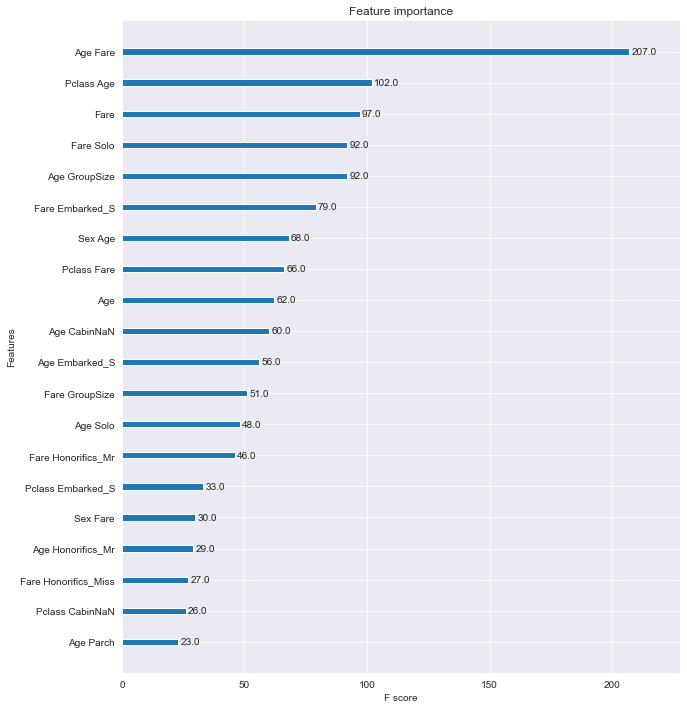

In [127]:
# weight
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Cover', ylabel='Features'>

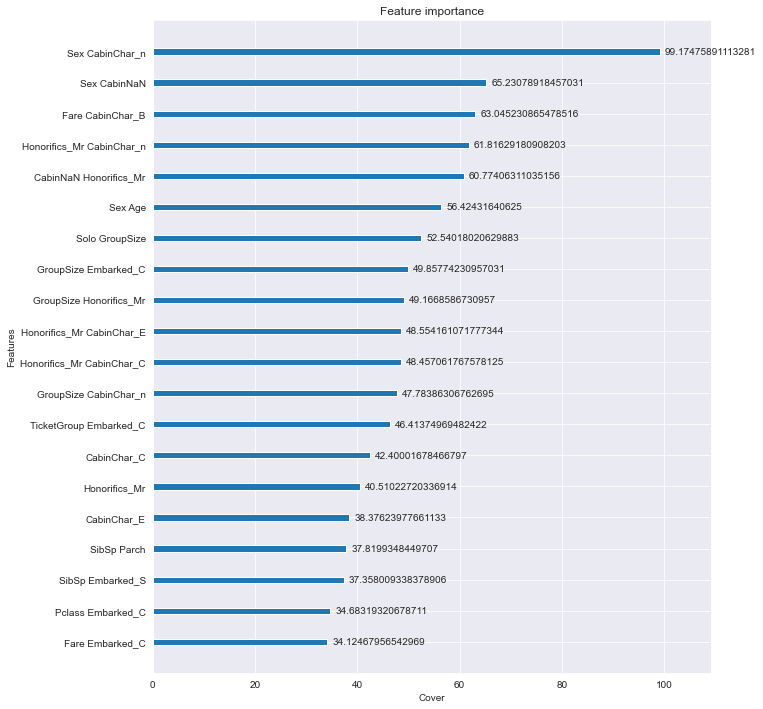

In [128]:
# cover
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax, importance_type="cover", xlabel="Cover")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Gain', ylabel='Features'>

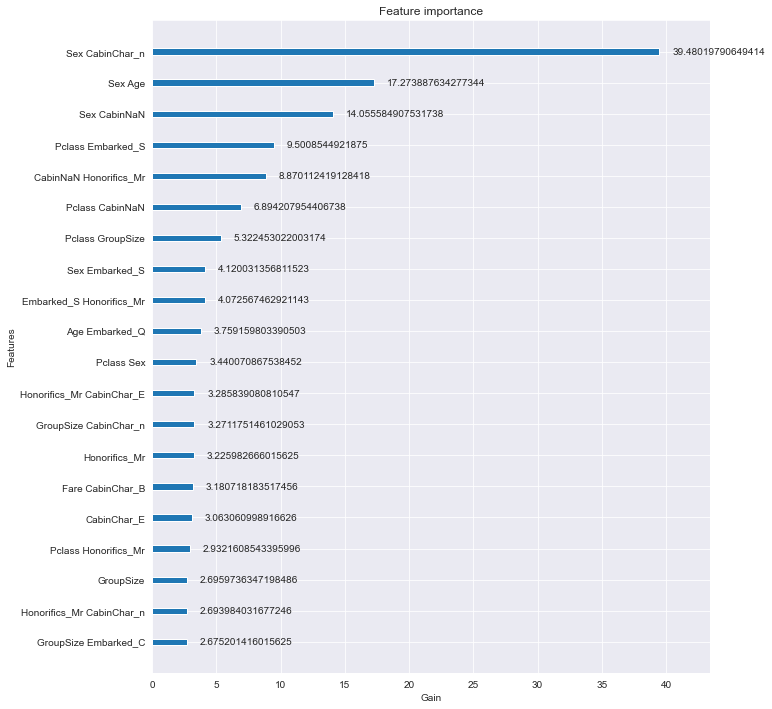

In [129]:
# gain
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax, importance_type="gain", xlabel="Gain")

XGBoost feature importance types:
- "weight" is the number of times a feature appears in a tree
- "gain" is the average gain of splits which use the feature
- "cover" is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

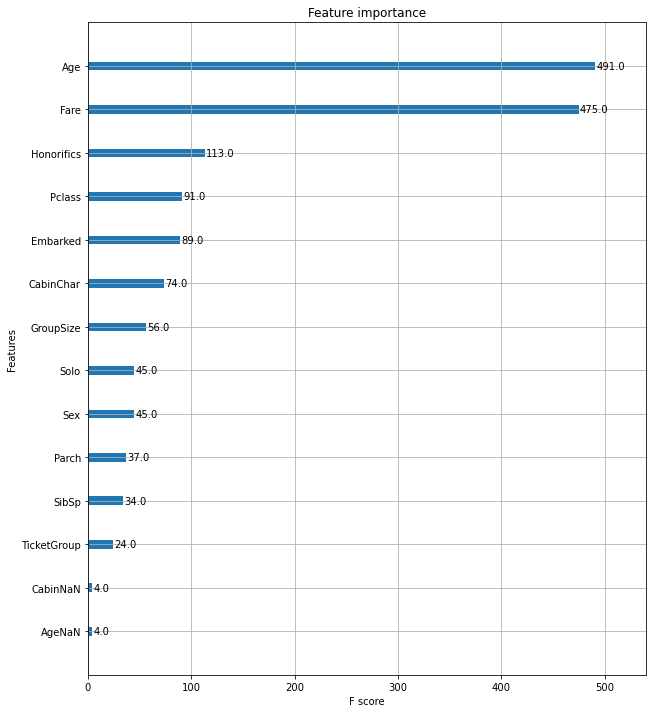

In [121]:
# weight
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Cover', ylabel='Features'>

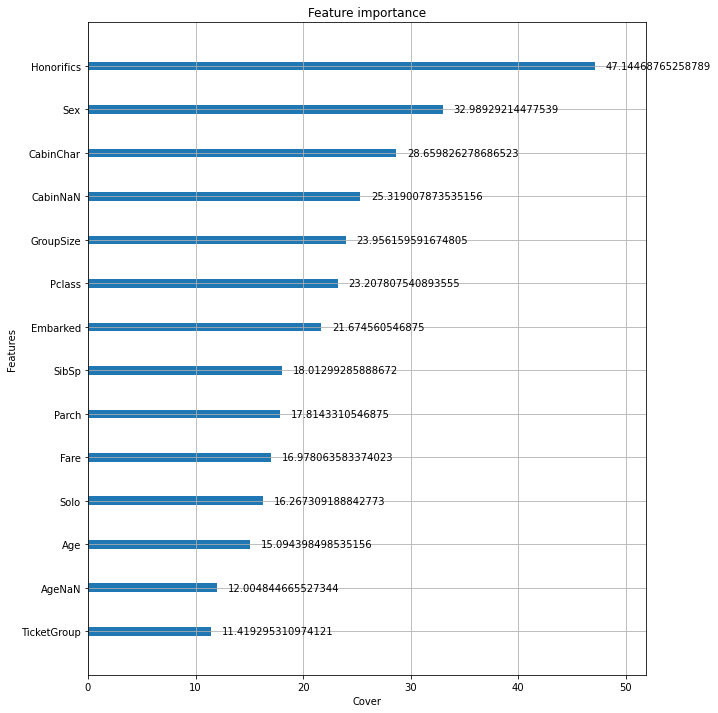

In [122]:
# cover
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax, importance_type="cover", xlabel="Cover")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Gain', ylabel='Features'>

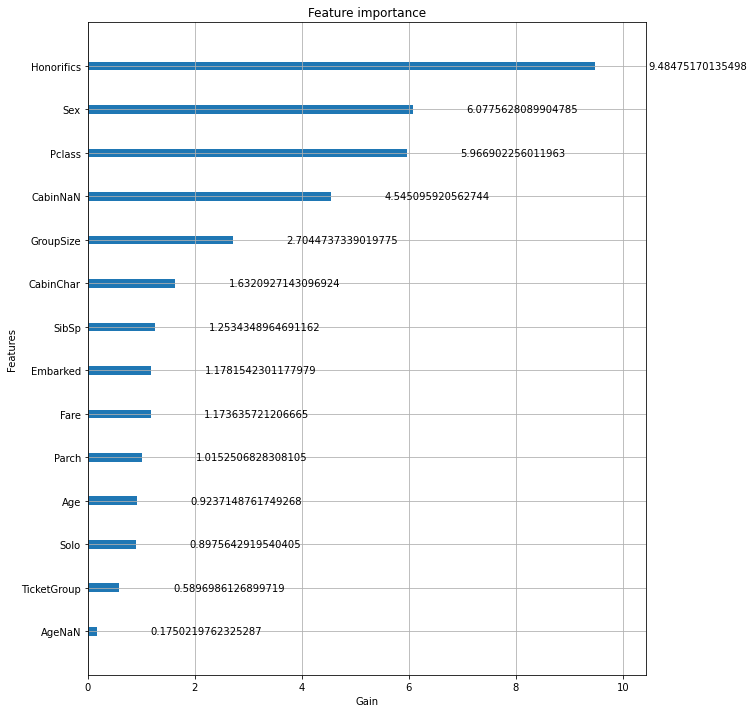

In [123]:
# gain
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax, importance_type="gain", xlabel="Gain")

### Running XGBoost to on selected features

In [124]:
titanic_logistic = titanic_logistic[selected_features]
X_train, X_val, y_train, y_val = train_test_split(titanic_logistic, y, test_size=0.2, random_state=42)
print('Train')
display(X_train.head())
print()
print('Val')
display(X_val.head())

Train


,Sex,Age,SibSp,Parch,Fare,Solo,AgeNaN,TicketGroup,GroupSize,Embarked_C,...,Honorifics_Mr CabinChar_C,Honorifics_Mr CabinChar_D,Honorifics_Mr CabinChar_E,Honorifics_Mr CabinChar_F,Honorifics_Mr CabinChar_n,Honorifics_Mrs CabinChar_C,Honorifics_Mrs CabinChar_E,Honorifics_Mrs CabinChar_n,Honorifics_Ms CabinChar_n,Honorifics_Rev CabinChar_n
312,1.0,32.000000,0.0,0.0,7.7500,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
586,1.0,20.000000,0.0,0.0,4.0125,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
24,0.0,63.000000,0.0,0.0,9.5875,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
160,1.0,52.000000,0.0,0.0,13.5000,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
552,1.0,29.426912,0.0,0.0,8.0500,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0



Val


,Sex,Age,SibSp,Parch,Fare,Solo,AgeNaN,TicketGroup,GroupSize,Embarked_C,...,Honorifics_Mr CabinChar_C,Honorifics_Mr CabinChar_D,Honorifics_Mr CabinChar_E,Honorifics_Mr CabinChar_F,Honorifics_Mr CabinChar_n,Honorifics_Mrs CabinChar_C,Honorifics_Mrs CabinChar_E,Honorifics_Mrs CabinChar_n,Honorifics_Ms CabinChar_n,Honorifics_Rev CabinChar_n
296,0.0,33.000000,1.0,0.0,53.1000,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
258,1.0,29.426912,0.0,0.0,7.8958,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
704,1.0,35.000000,0.0,0.0,26.0000,1.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
359,1.0,29.426912,0.0,0.0,13.0000,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
250,0.0,45.000000,1.0,1.0,26.2500,0.0,0.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [125]:
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns, enable_categorical=True)
dval = xgb.DMatrix(X_val, y_val, feature_names=X_train.columns, enable_categorical=True)

In [126]:
clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=1500, evals=[(dtrain, "Train"), (dval, "Val")], 
                verbose_eval= 250, early_stopping_rounds=100)

[15:46:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	Train-auc:0.87465	Val-auc:0.83826
[113]	Train-auc:0.98017	Val-auc:0.85994


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

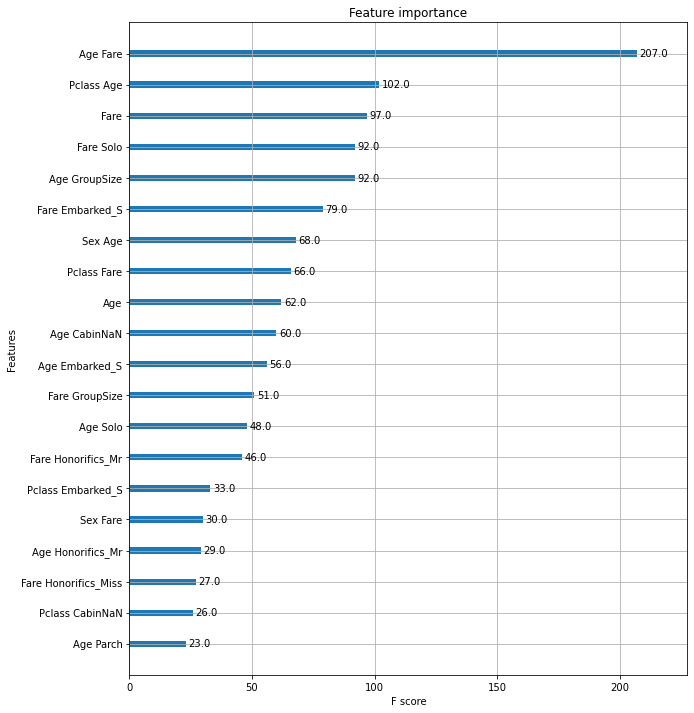

In [127]:
# weight
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Cover', ylabel='Features'>

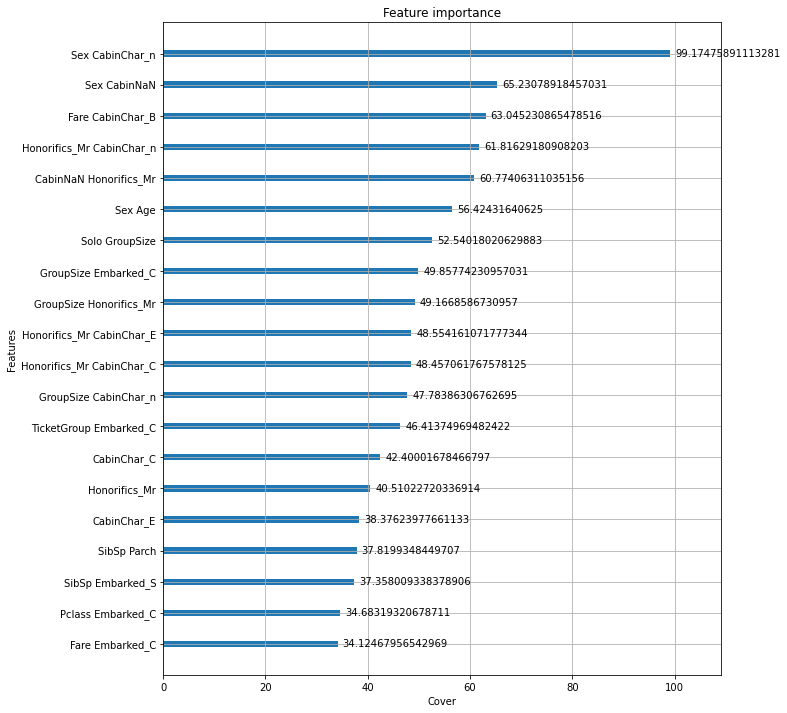

In [128]:
# cover
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax, importance_type="cover", xlabel="Cover")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Gain', ylabel='Features'>

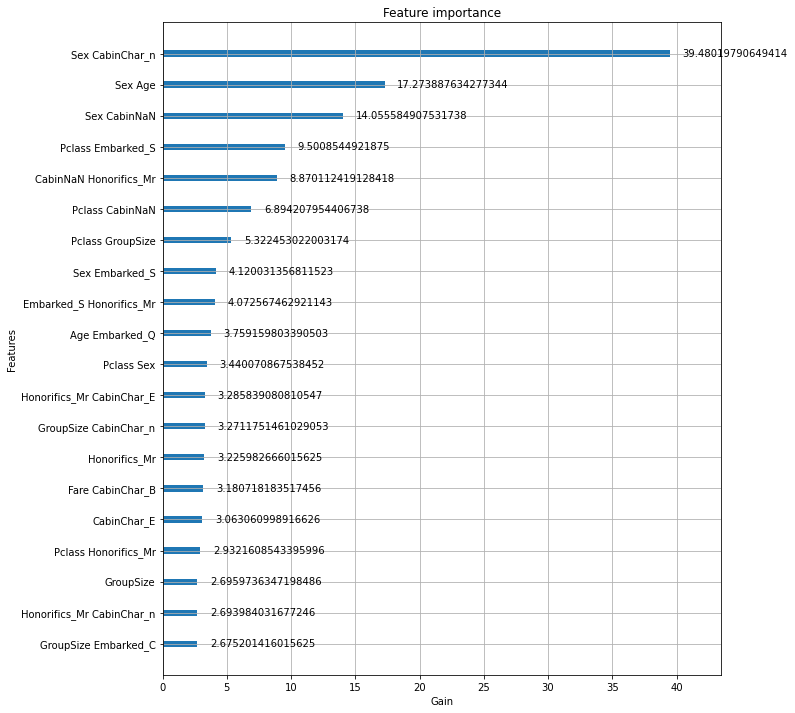

In [129]:
# gain
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax, importance_type="gain", xlabel="Gain")